# EIS Dataset

In [44]:
import os
import re
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [45]:
# ------------------------
# 🔍 Metadata Parser
# ------------------------
def parse_filename_metadata(filename: str):
    pattern = r"Cell(\d+)_([0-9]+)SOH_([0-9]+)degC_([0-9]+)SOC_([0-9]+)"
    match = re.search(pattern, filename)
    if match:
        return {
            "CellID": f"Cell{match.group(1)}",
            "SOH": int(match.group(2)),
            "Temp": int(match.group(3)),
            "SOC": int(match.group(4)),
            "RealSOH": int(match.group(5)) / 100
        }
    return None

In [46]:
# ------------------------
# 📥 Load All EIS .mat Files
# ------------------------
def load_all_eis_mat_files(folder_path: str):
    all_data = []
    folder = Path(folder_path)
    mat_files = list(folder.glob("*.mat"))

    for file in tqdm(mat_files, desc="Loading EIS files"):
        meta = parse_filename_metadata(file.stem)
        if meta is None:
            continue
        try:
            mat = scipy.io.loadmat(file)
            for value in mat.values():
                if isinstance(value, (list, tuple)):
                    continue
                if hasattr(value, 'shape') and value.ndim == 2 and value.shape[1] >= 3:
                    df = pd.DataFrame(value[:, :3], columns=["Frequency(Hz)", "Re(Z)", "Im(Z)"])
                    df = df.assign(**meta)
                    all_data.append(df)
                    break
        except Exception as e:
            print(f"⚠️ Error reading {file.name}: {e}")

    if not all_data:
        raise ValueError("No valid .mat files loaded.")
    return pd.concat(all_data, ignore_index=True)


In [47]:
# ------------------------
# 📊 Summary Plots
# ------------------------
def plot_metadata_distribution(df_meta):
    plt.figure(figsize=(16, 10))
    for i, (col, title, color) in enumerate(zip(
        ['SOH', 'SOC', 'Temp', 'CellID'],
        ["SOH", "SOC", "Temperature", "CellID"],
        ['skyblue', 'lightgreen', 'salmon', 'plum']
    )):
        plt.subplot(2, 2, i + 1)
        df_meta[col].value_counts().sort_index().plot(kind='bar', color=color)
        plt.title(f"Sample Count by {title}")
        plt.xlabel(title)
        plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

In [48]:
# ------------------------
# 📊 Grouped Bar Chart by Temp
# ------------------------
def plot_grouped_bar_by_temp(df_meta):
    sns.set(style="whitegrid", font_scale=1.1)
    temps = sorted(df_meta["Temp"].unique())
    fig, axes = plt.subplots(1, len(temps), figsize=(6 * len(temps), 6), sharey=True)
    colors = sns.color_palette("husl", len(df_meta["SOH"].unique()))

    for i, temp in enumerate(temps):
        ax = axes[i]
        temp_df = df_meta[df_meta["Temp"] == temp]
        pivot = temp_df.groupby(["SOC", "SOH"]).size().unstack(fill_value=0).sort_index()
        pivot.plot(kind="bar", stacked=False, color=colors, edgecolor="black", ax=ax)
        ax.set_title(f"Temperature: {temp}°C")
        ax.set_xlabel("SOC")
        if i == 0:
            ax.set_ylabel("Sample Count")
        ax.grid(axis='y', linestyle='--', alpha=0.6)

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, title="SOH", loc="center right")
    plt.suptitle("📊 SOH Distribution per SOC (Grouped by Temp)", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 0.88, 0.95])
    plt.show()


In [49]:
# ------------------------
# 🔮 t-SNE Projection
# ------------------------
def run_tsne_projection(eis_df):
    grouped = eis_df.groupby(['CellID', 'SOH', 'SOC', 'Temp'])
    features, labels = [], []

    for (cell, soh, soc, temp), group in grouped:
        g_sorted = group.sort_values("Frequency(Hz)")
        vec = np.concatenate([g_sorted['Re(Z)'].values, g_sorted['Im(Z)'].values])
        features.append(vec)
        labels.append({"CellID": cell, "SOH": soh, "SOC": soc, "Temp": temp})

    X = np.array(features)
    df_labels = pd.DataFrame(labels)
    X_pca = PCA(n_components=50).fit_transform(X)
    X_tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42).fit_transform(X_pca)

    df_labels['TSNE-1'] = X_tsne[:, 0]
    df_labels['TSNE-2'] = X_tsne[:, 1]

    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df_labels, x="TSNE-1", y="TSNE-2", hue="SOH", style="Temp", palette="tab10", s=70)
    plt.title("t-SNE Projection of EIS Spectra", fontsize=15, weight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [50]:
# ------------------------
# 🔁 Nyquist Plot Grid by Temp
# ------------------------
def plot_full_nyquist_grid_all_cells(eis_df):
    temps = sorted(eis_df["Temp"].unique())
    sohs = sorted(eis_df["SOH"].unique(), reverse=True)
    socs = sorted(eis_df["SOC"].unique())

    for temp in temps:
        df_temp = eis_df[eis_df["Temp"] == temp]
        unique_cells = sorted(df_temp["CellID"].unique())
        palette = sns.color_palette("husl", len(unique_cells))
        cell_color_map = dict(zip(unique_cells, palette))

        fig, axes = plt.subplots(len(socs), len(sohs), figsize=(20, 16), sharex=True, sharey=True)
        fig.suptitle(f"Nyquist Curves by SOC vs SOH @ {temp}°C", fontsize=18, weight='bold')

        for i, soc in enumerate(socs):
            for j, soh in enumerate(sohs):
                ax = axes[i, j]
                subset = df_temp[(df_temp["SOC"] == soc) & (df_temp["SOH"] == soh)]

                if subset.empty:
                    ax.set_title(f"{soh}% SoH", fontsize=9)
                    ax.set_xticks([]); ax.set_yticks([])
                    continue

                for cell_id in subset["CellID"].unique():
                    group = subset[subset["CellID"] == cell_id].sort_values("Frequency(Hz)")
                    ax.plot(group["Re(Z)"], -group["Im(Z)"], label=cell_id, color=cell_color_map[cell_id], linewidth=1.2)

                ax.set_title(f"{soh}% SoH", fontsize=9)
                if j == 0: ax.set_ylabel(f"{soc}% SoC", fontsize=9)
                if i == len(socs) - 1: ax.set_xlabel("Re(Z)", fontsize=9)
                ax.tick_params(labelsize=8)
                ax.grid(True, linestyle='--', alpha=0.4)

        handles = [plt.Line2D([0], [0], color=cell_color_map[c], lw=2) for c in unique_cells]
        labels = unique_cells
        fig.legend(handles, labels, title="CellID", loc='center right', bbox_to_anchor=(1.01, 0.5), fontsize=8)
        plt.tight_layout(rect=[0, 0, 0.97, 0.96])
        plt.show()


In [51]:
# Load your EIS dataset
eis_folder_path = r"C:\Users\tmgon\OneDrive - Edith Cowan University\00 - Megallan Power\NMC Batteries Warwick Station\NMC\DIB_Data\EIS_Test_mat_files"
eis_df = load_all_eis_mat_files(eis_folder_path)



Loading EIS files: 100%|██████████| 360/360 [00:01<00:00, 226.07it/s]


In [52]:
# Preview the data
eis_df.head()

,Frequency(Hz),Re(Z),Im(Z),CellID,SOH,Temp,SOC,RealSOH
0,10000.0,0.02995,0.03160,Cell02,95,15,5,95.05
1,7943.0,0.02827,0.02617,Cell02,95,15,5,95.05
2,6310.0,0.02704,0.02143,Cell02,95,15,5,95.05
3,5012.0,0.02599,0.01736,Cell02,95,15,5,95.05
4,3981.0,0.02499,0.01377,Cell02,95,15,5,95.05


In [10]:
eis_df.describe()

,Frequency(Hz),Re(Z),Im(Z),SOH,Temp,SOC,RealSOH
count,21960.000000,21960.000000,21960.000000,21960.000000,21960.000000,21960.000000,21960.00000
mean,797.097582,0.029719,0.000229,90.000000,25.000000,48.000000,90.34750
std,1951.144325,0.007403,0.007416,7.217043,8.165152,32.650399,7.21319
min,0.010000,0.022610,-0.035230,80.000000,15.000000,5.000000,80.46000
25%,0.316200,0.025330,-0.002455,85.000000,15.000000,20.000000,83.07250
50%,10.000000,0.027710,-0.001167,90.000000,25.000000,50.000000,90.67000
75%,316.200000,0.031280,-0.000125,95.000000,35.000000,70.000000,96.12750
max,10000.000000,0.087100,0.035420,100.000000,35.000000,95.000000,100.00000


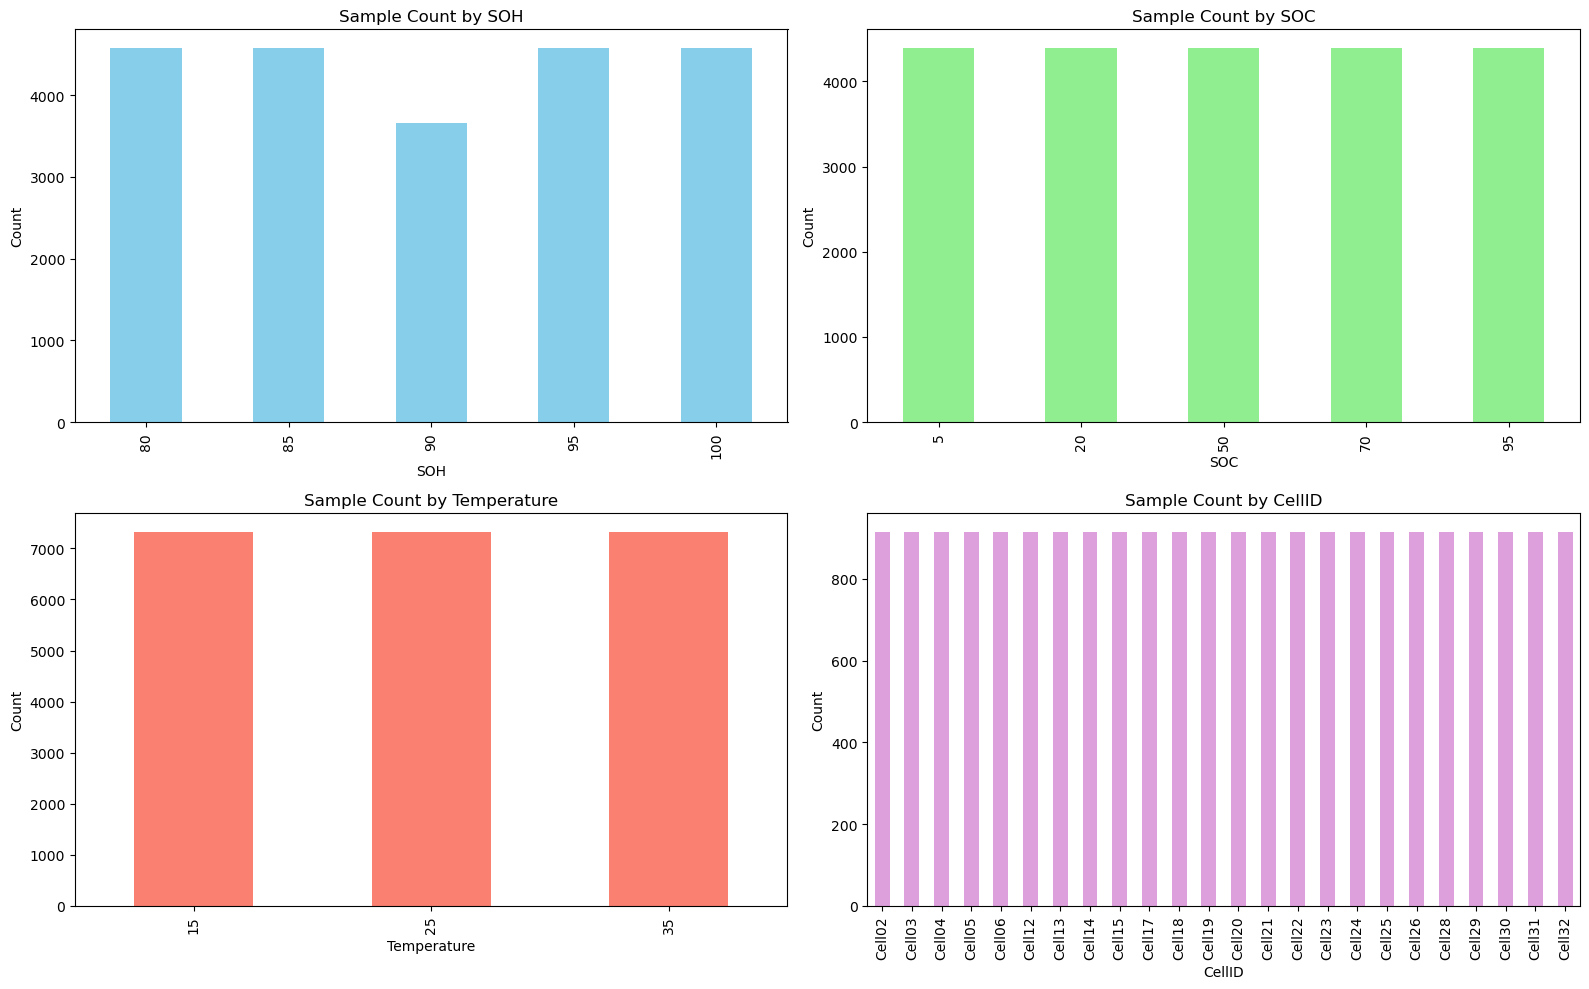

In [11]:
# Metadata summary plots
plot_metadata_distribution(eis_df)



C:\Users\tmgon\AppData\Local\Temp\ipykernel_38548\99719366.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 0.88, 0.95])
C:\Users\tmgon\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


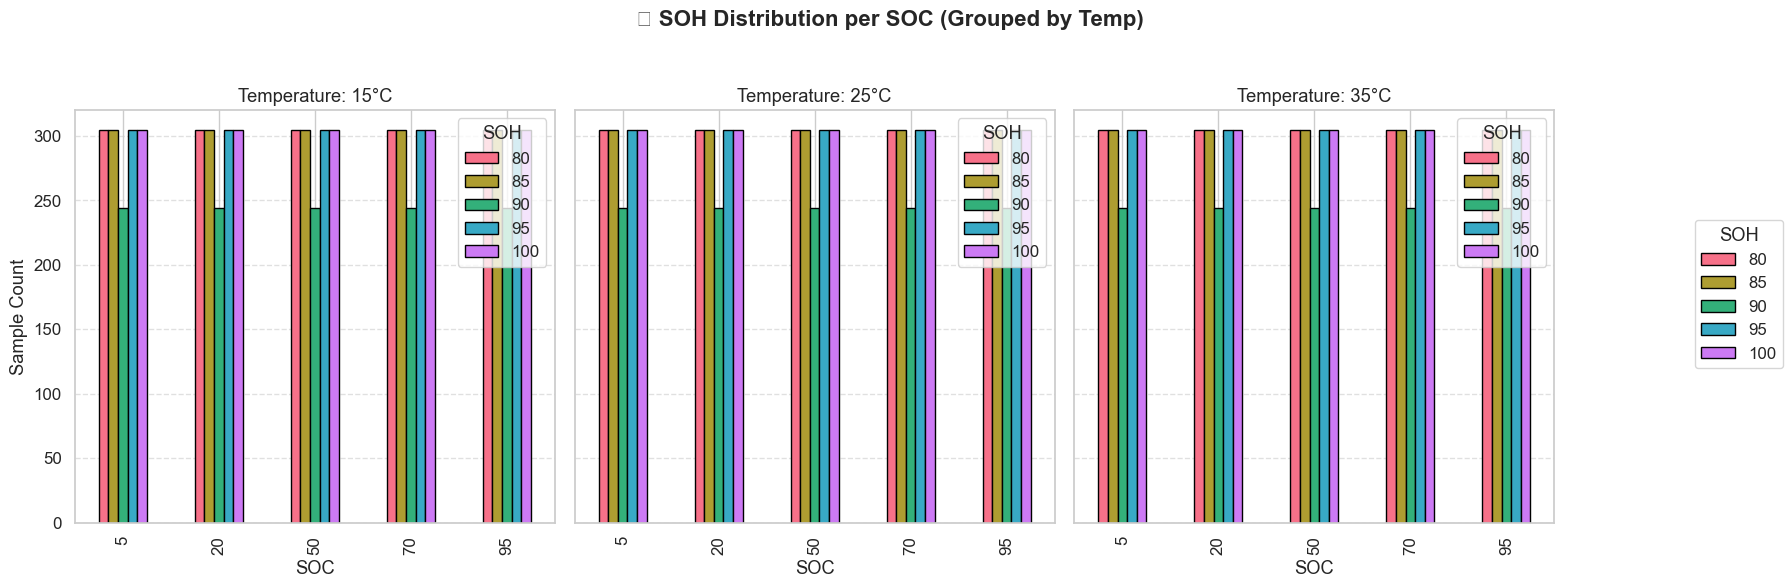

In [12]:
# Grouped bar chart by temperature
plot_grouped_bar_by_temp(eis_df)



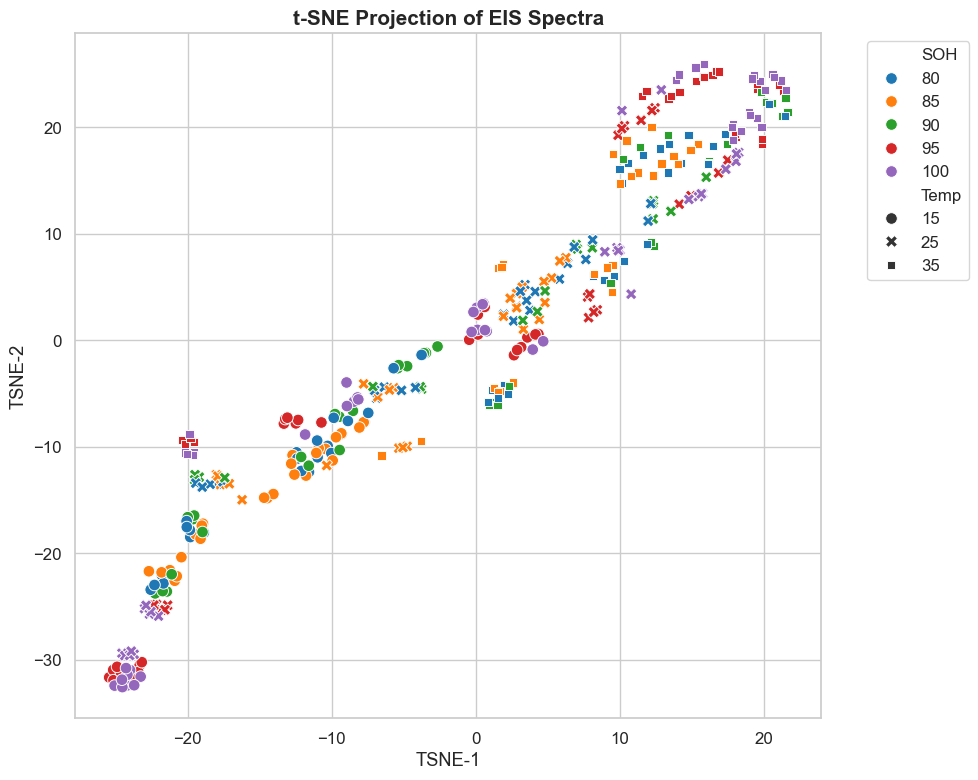

In [13]:
# t-SNE projection plot
run_tsne_projection(eis_df)



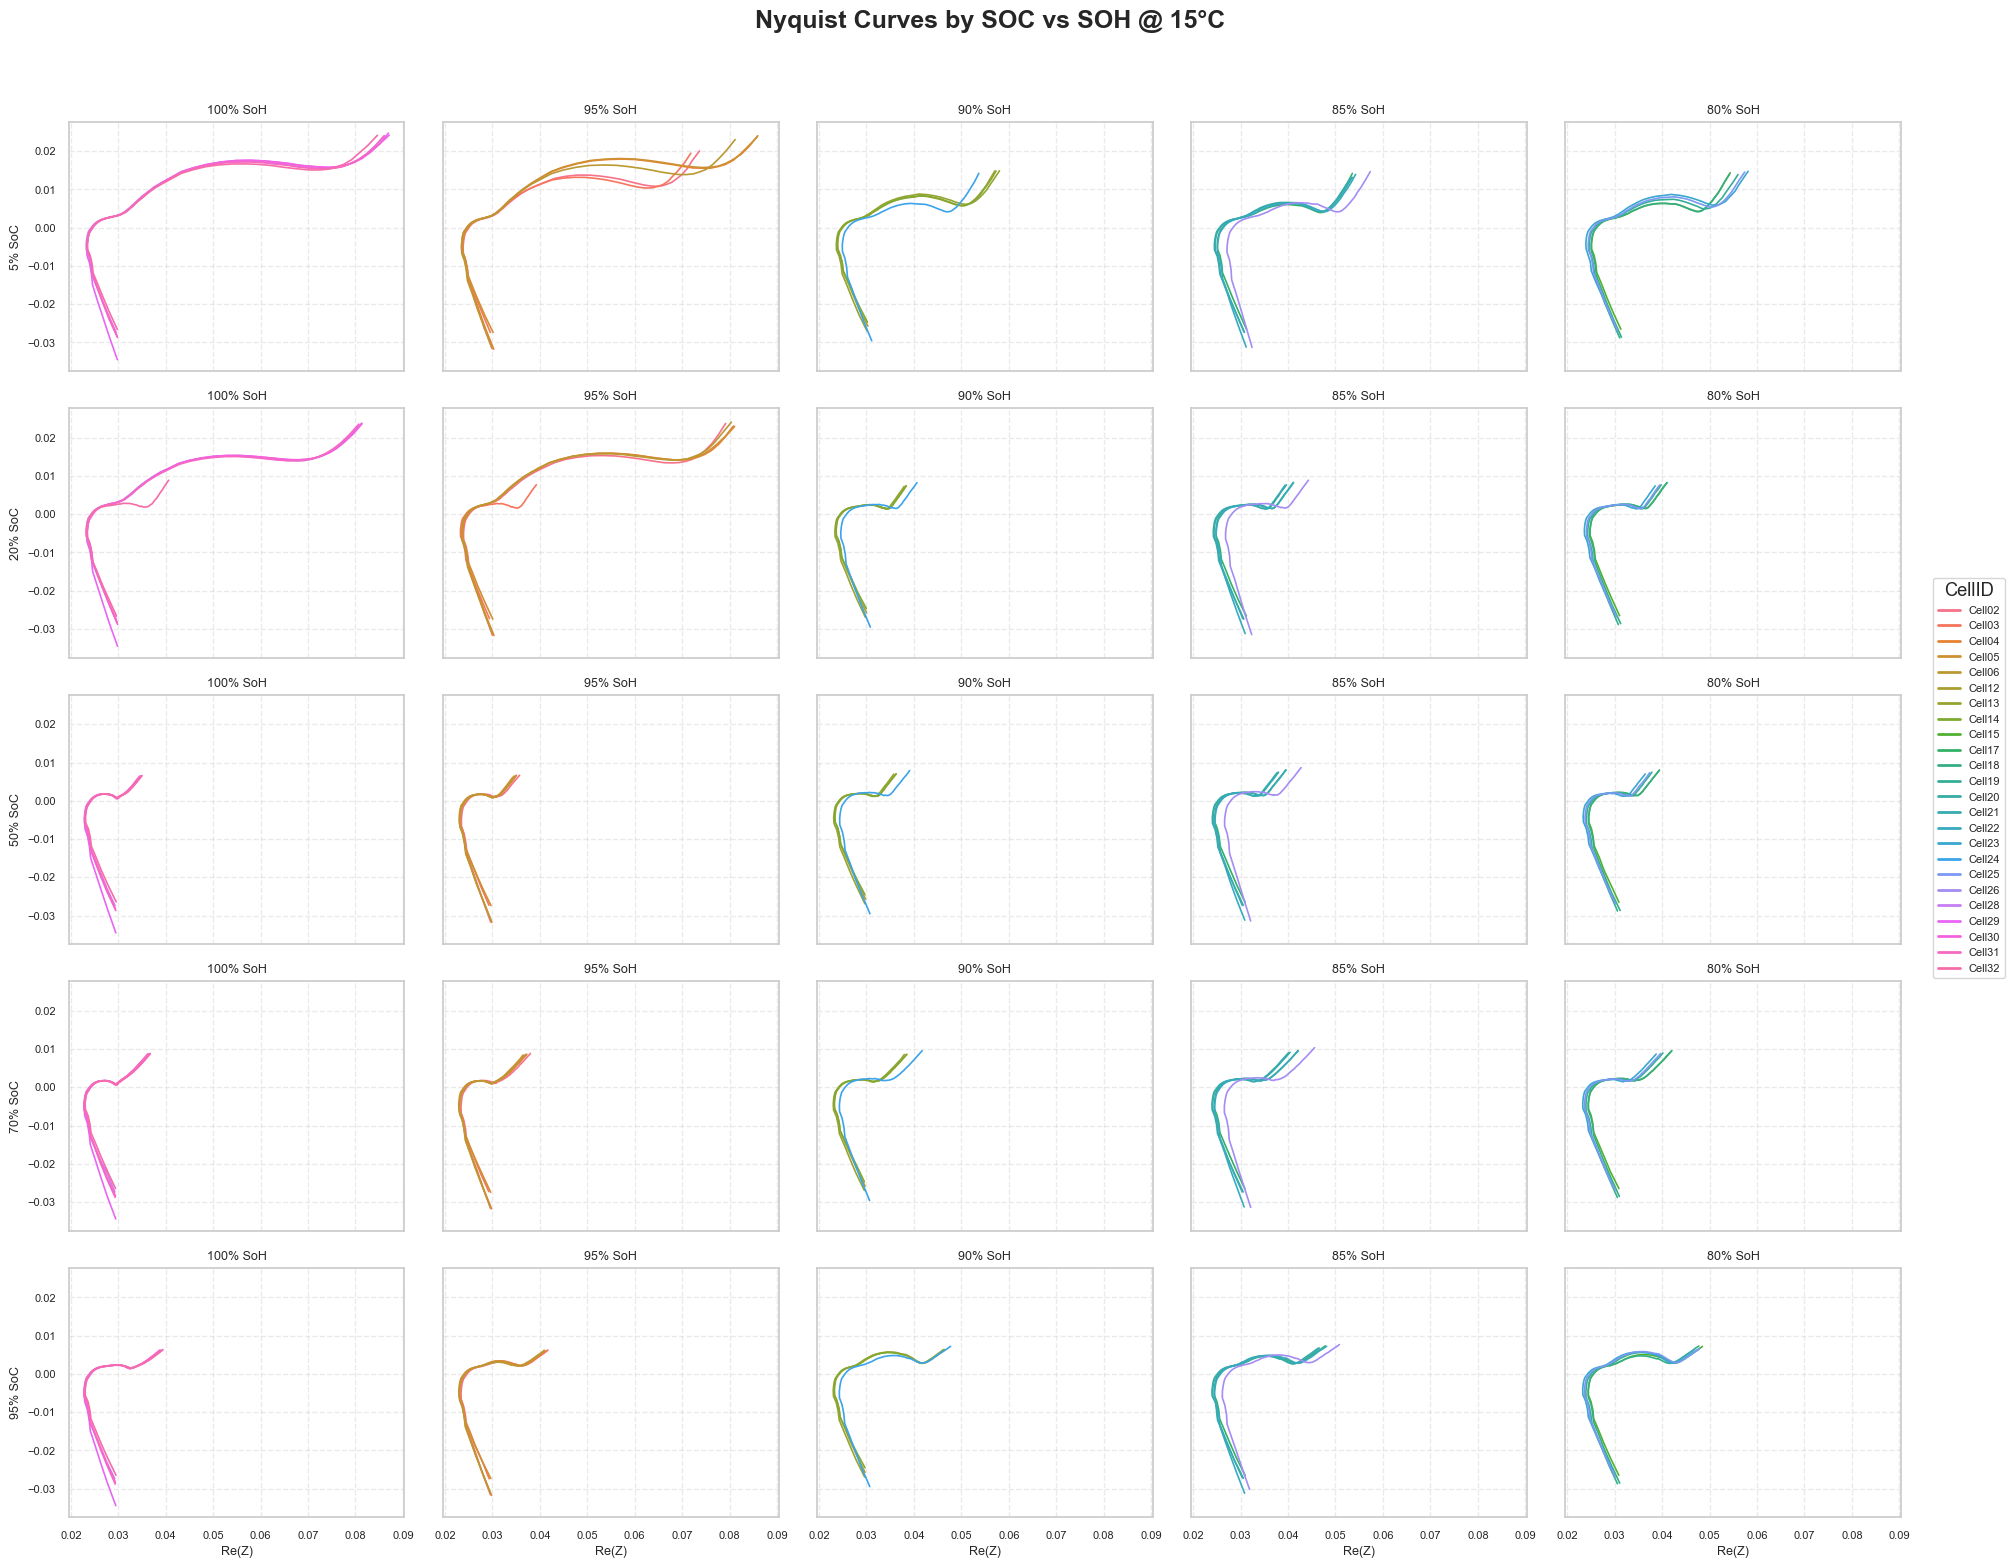

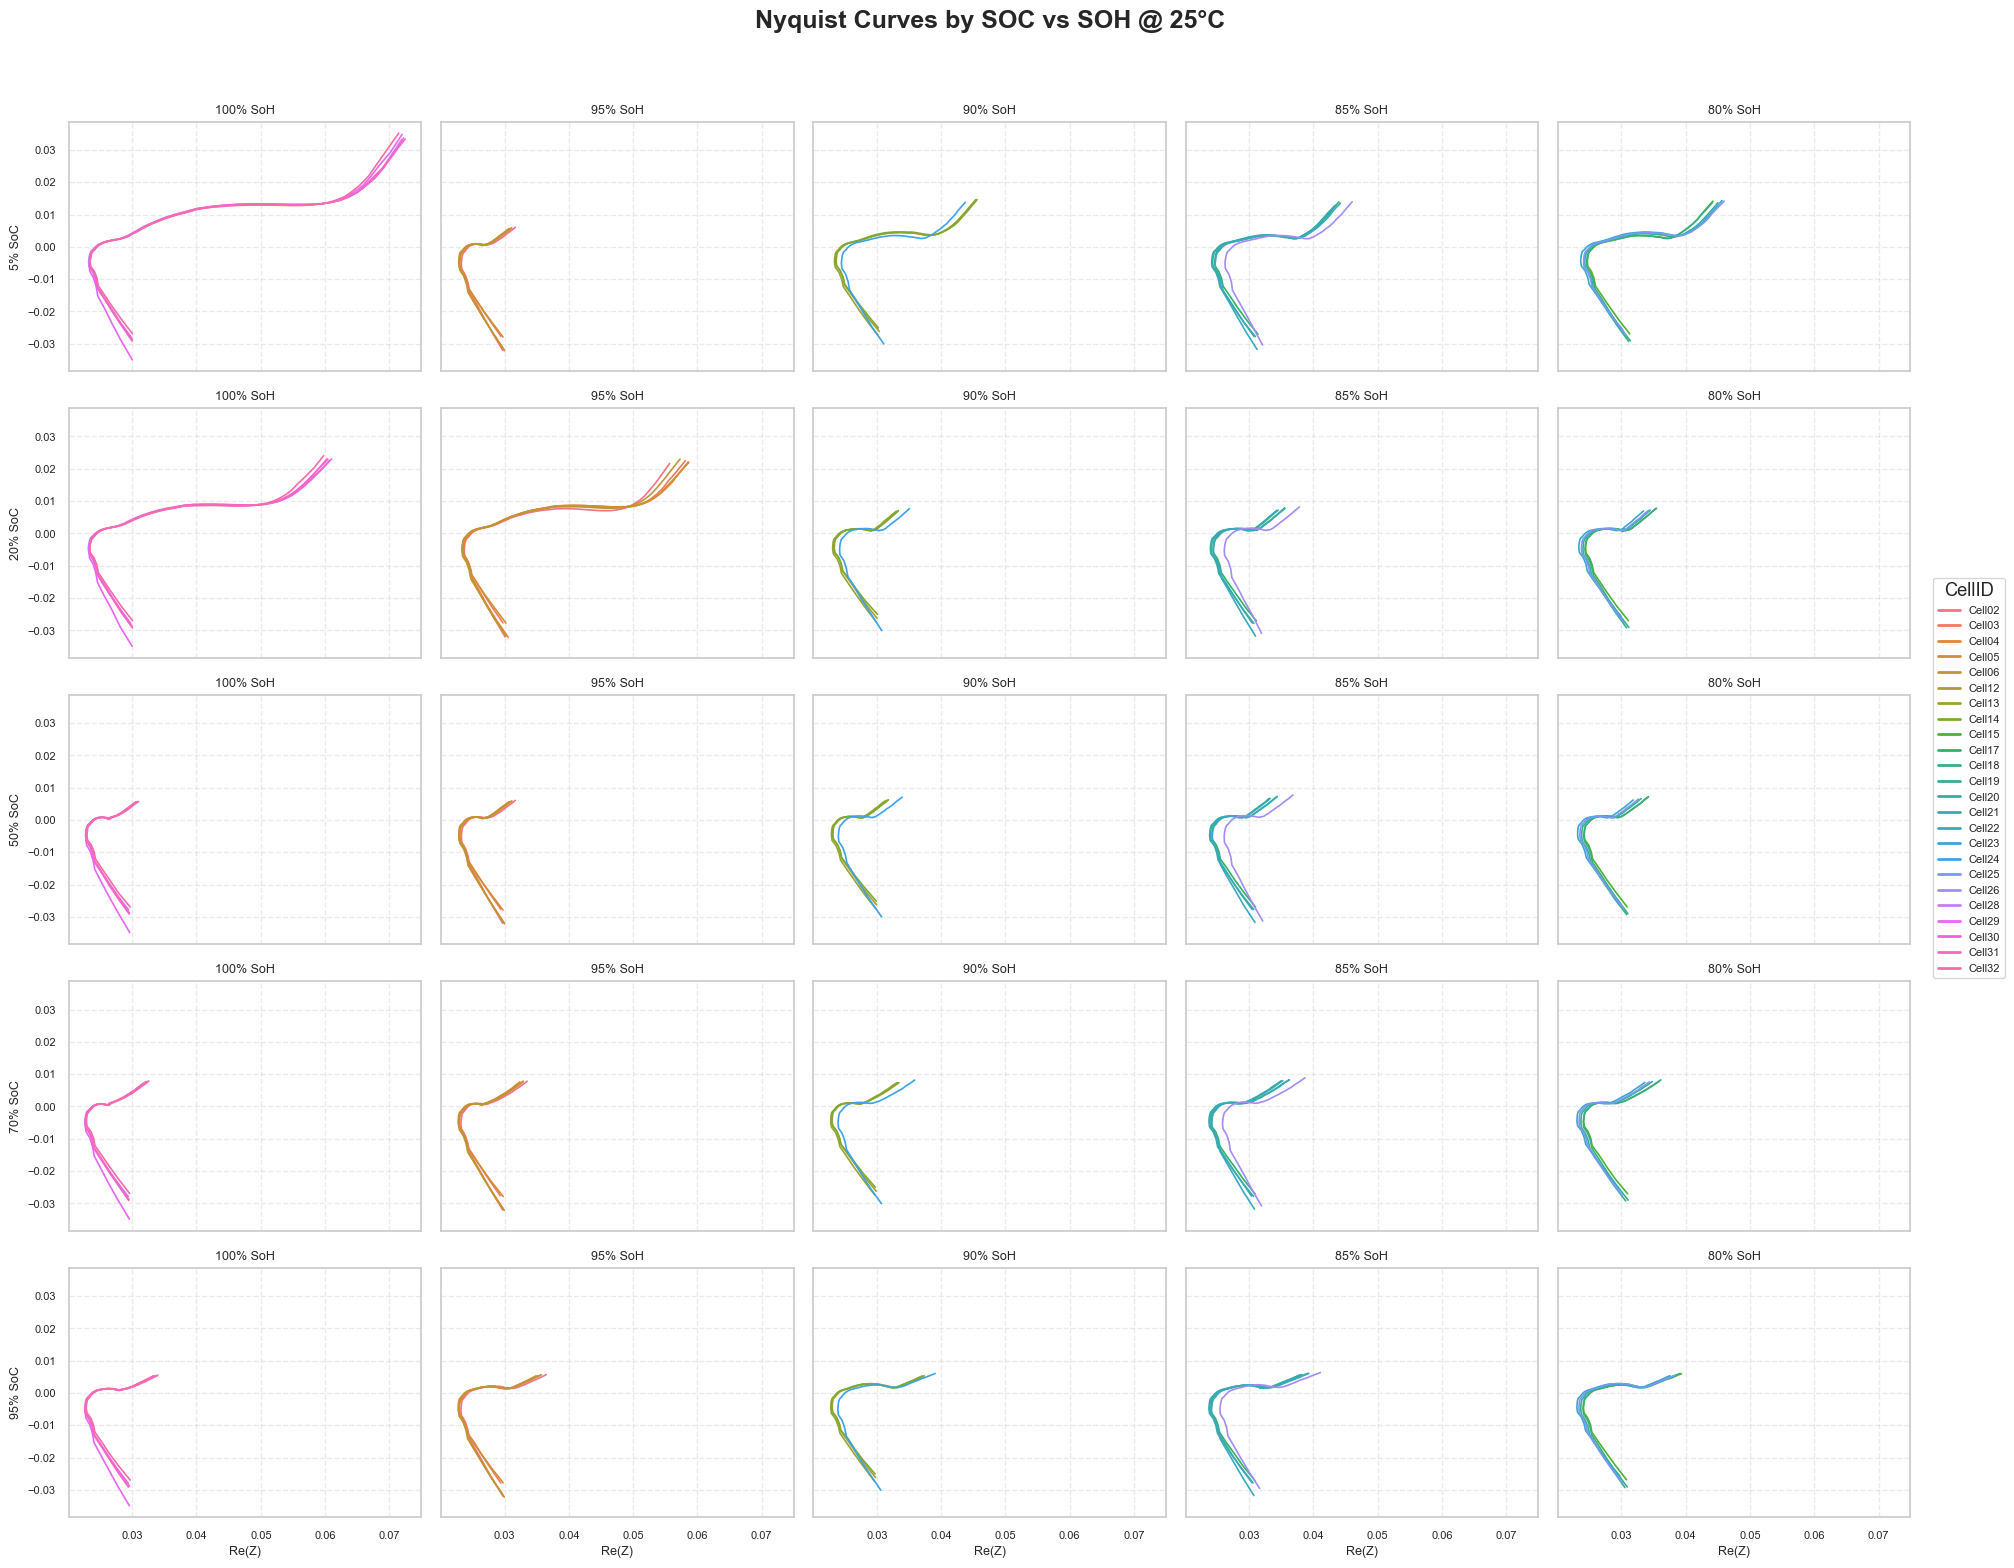

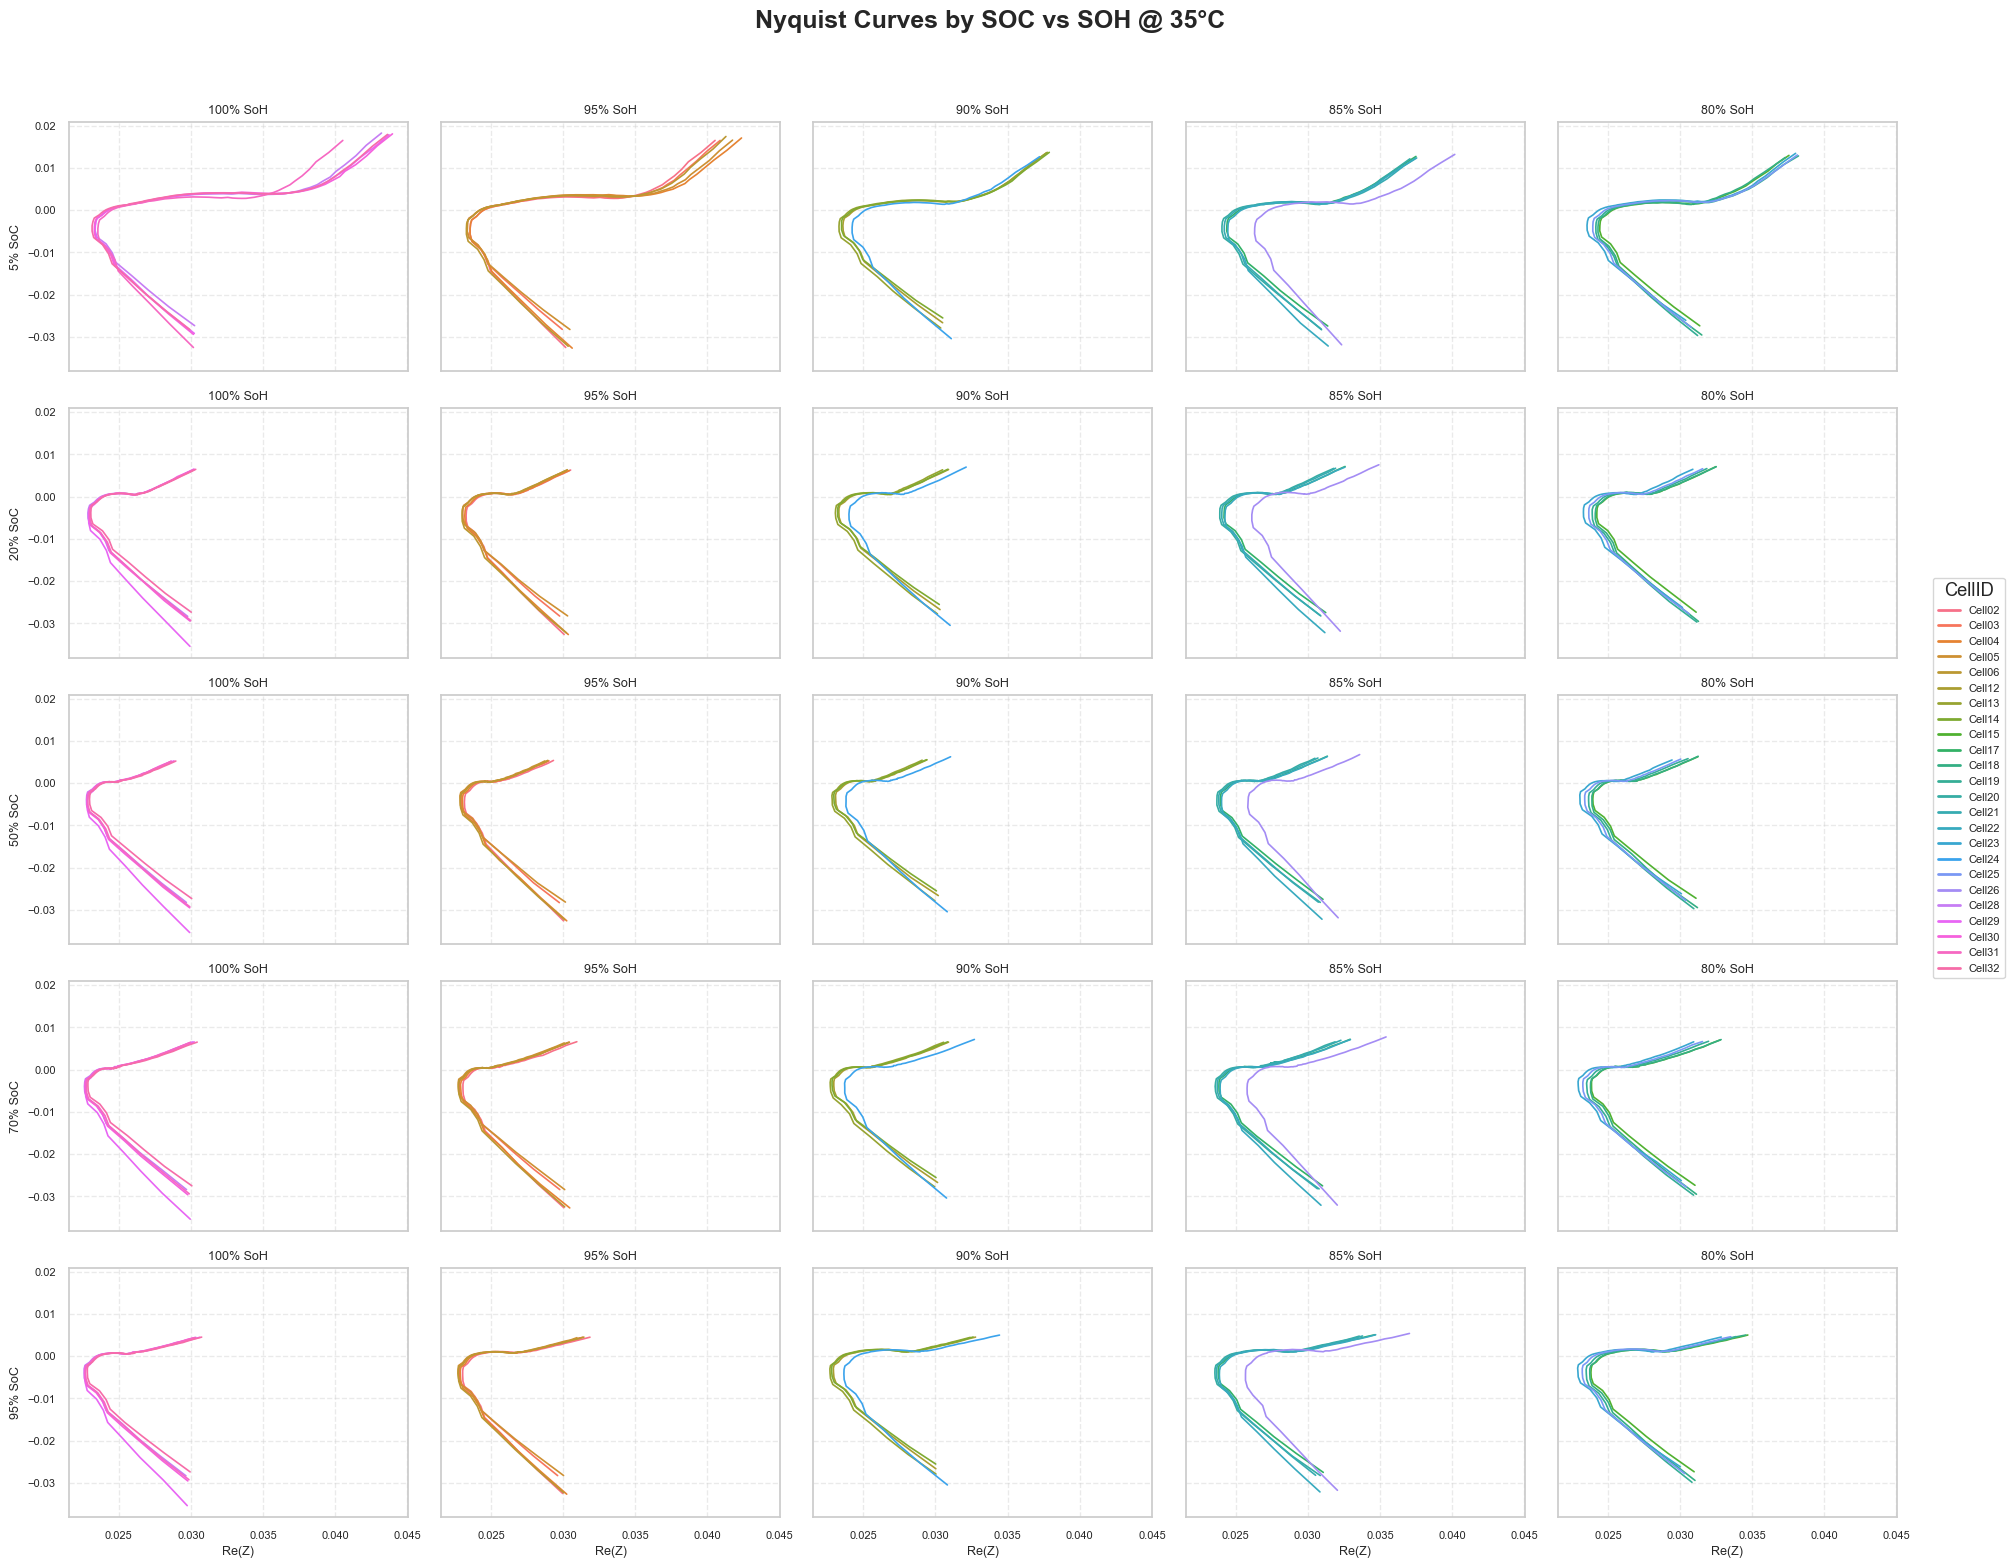

In [14]:
# Nyquist plots
plot_full_nyquist_grid_all_cells(eis_df)


# Load Capacity Data

In [15]:

# ------------------------
# 📁 Configuration
# ------------------------
BASE_DIR = Path(
    r"C:\Users\tmgon\OneDrive - Edith Cowan University"
    r"\00 - Megallan Power\NMC Batteries Warwick Station"
    r"\NMC\DIB_Data\.matfiles\Capacity_Check"
)

# ------------------------
# 📂 Step 1: Collect & List all .mat files
# ------------------------
mat_paths = sorted(BASE_DIR.rglob("*.mat"))
print(f"✅ Found {len(mat_paths)} .mat files. Showing first 237:")
for p in mat_paths[:237]:
    print("•", p.relative_to(BASE_DIR))

# ------------------------
# 🔧 Loader: .mat → DataFrame
# ------------------------
def load_capacity_mat_to_df(fp: Path) -> pd.DataFrame:
    mat = scipy.io.loadmat(fp)
    raw = mat['data'][0, 0]
    names = [str(n[0]) for n in mat['channelNames'][0]]
    cols  = [c.flatten() for c in raw]
    L = min(len(c) for c in cols)
    return pd.DataFrame({n: c[:L] for n, c in zip(names, cols)})



✅ Found 237 .mat files. Showing first 237:
• 100per_Cells_Capacity_Check_09112021_000cycle\Cell27_100SOH_Capacity_Check_25degC_000cycle.mat
• 100per_Cells_Capacity_Check_09112021_000cycle\Cell28_100SOH_Capacity_Check_25degC_000cycle.mat
• 100per_Cells_Capacity_Check_09112021_000cycle\Cell29_100SOH_Capacity_Check_25degC_000cycle.mat
• 100per_Cells_Capacity_Check_09112021_000cycle\Cell30_100SOH_Capacity_Check_25degC_000cycle.mat
• 100per_Cells_Capacity_Check_09112021_000cycle\Cell31_100SOH_Capacity_Check_25degC_000cycle.mat
• 100per_Cells_Capacity_Check_09112021_000cycle\Cell32_100SOH_Capacity_Check_25degC_000cycle.mat
• 80per_Cells_Capacity_Check_08122021_080cycle\Cell15_80SOH_Capacity_Check_25degC_080cycle.mat
• 80per_Cells_Capacity_Check_08122021_080cycle\Cell17_80SOH_Capacity_Check_25degC_080cycle.mat
• 80per_Cells_Capacity_Check_08122021_080cycle\Cell18_80SOH_Capacity_Check_25degC_080cycle.mat
• 80per_Cells_Capacity_Check_08122021_080cycle\Cell22_80SOH_Capacity_Check_25degC_080cycle

In [16]:
# ------------------------
# 👁️ Step 2: Preview first file
# ------------------------
if mat_paths:
    first_fp = mat_paths[0]
    print(f"\n🔍 Previewing: {first_fp.name}")
    try:
        df = load_capacity_mat_to_df(first_fp)
        display(df.head())    # in Jupyter; use print(df.head()) otherwise
        print("📋 Columns:", df.columns.tolist())
    except Exception as e:
        print("❌ Load error:", e)




🔍 Previewing: Cell27_100SOH_Capacity_Check_25degC_000cycle.mat


,Step,Status,Step Time,Prog Time,Cycle,Cycle Level,Procedure,Voltage,Current,AhAccu,AhPrev,WhAccu,Watt,LogTemp001
0,1,PAU,1.024,1.117,0,0,LTA_LG50_RPT_Cyc,3.70063,0.0,0.0,0.0,0.0,0.0,25.5
1,1,PAU,2.069,2.162,0,0,LTA_LG50_RPT_Cyc,3.70063,0.0,0.0,0.0,0.0,0.0,25.5
2,1,PAU,3.039,3.132,0,0,LTA_LG50_RPT_Cyc,3.70052,0.0,0.0,0.0,0.0,0.0,25.5
3,1,PAU,4.049,4.142,0,0,LTA_LG50_RPT_Cyc,3.70040,0.0,0.0,0.0,0.0,0.0,25.5
4,1,PAU,5.165,5.258,0,0,LTA_LG50_RPT_Cyc,3.70040,0.0,0.0,0.0,0.0,0.0,25.5


📋 Columns: ['Step', 'Status', 'Step Time', 'Prog Time', 'Cycle', 'Cycle Level', 'Procedure', 'Voltage', 'Current', 'AhAccu', 'AhPrev', 'WhAccu', 'Watt', 'LogTemp001']


In [17]:
# ------------------------
# 🧠 Step 3: Extract metadata from filenames
# ------------------------
pattern = re.compile(
    r"Cell(?P<cell>\d+)_"
    r"(?P<soh>\d+)SOH_"
    r"Capacity_Check_(?P<temp>\d+)degC_"
    r"(?P<cycle>\d+)cycle"
)
records = []
for fp in mat_paths:
    m = pattern.search(fp.name)
    if not m: 
        continue
    records.append({
        "CellID":  f"Cell{m.group('cell')}",
        "SOH":     int(m.group('soh')),
        "Temp":    int(m.group('temp')),
        "Cycle":   int(m.group('cycle'))
    })

df_meta = pd.DataFrame(records)
df_meta["CellID"] = df_meta["CellID"].astype("category")



C:\Users\tmgon\AppData\Local\Temp\ipykernel_38548\3917254299.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="SOH", data=df_meta, ax=axes[0,0], palette=palette)
C:\Users\tmgon\AppData\Local\Temp\ipykernel_38548\3917254299.py:10: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.countplot(x="SOH", data=df_meta, ax=axes[0,0], palette=palette)
C:\Users\tmgon\AppData\Local\Temp\ipykernel_38548\3917254299.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Temp", data=df_meta, ax=axes[1,0], palette=palette)
C:\Users\tmgon\AppData\Local\Temp\ipykernel_38548\3917254299.py:18: UserWarning: The palette list has more values (10) than 

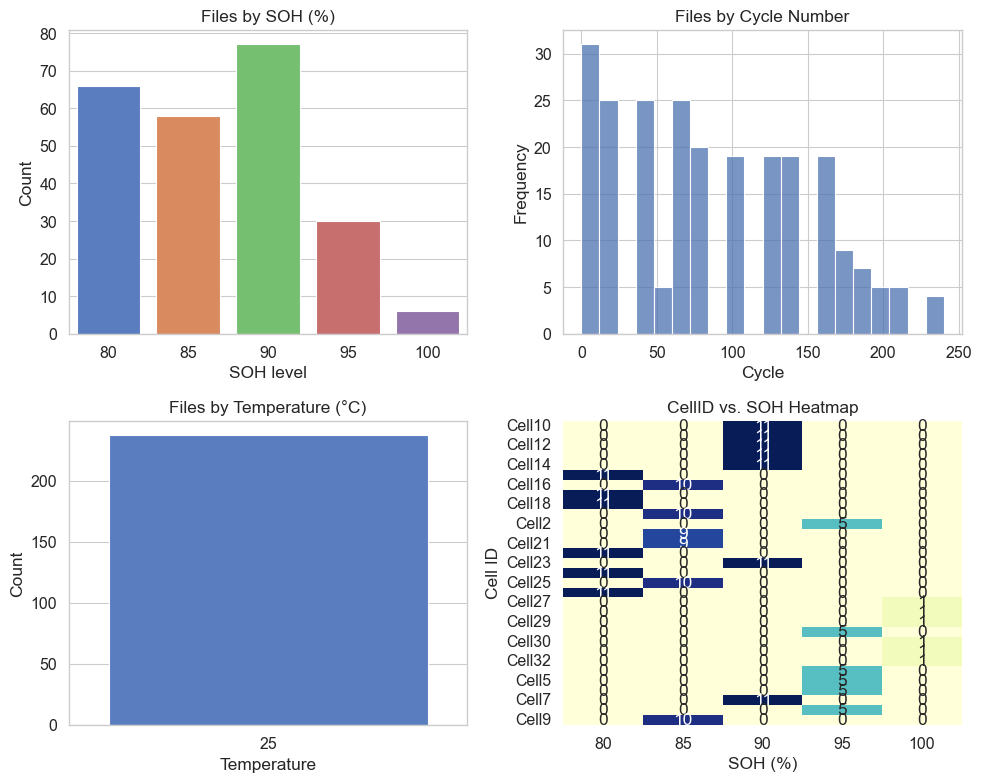

In [18]:
# ------------------------
# 📈 Step 4: Publication-quality plotting
# ------------------------
sns.set_theme(context="paper", style="whitegrid", font_scale=1.3)
palette = sns.color_palette("muted")

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# SOH distribution
sns.countplot(x="SOH", data=df_meta, ax=axes[0,0], palette=palette)
axes[0,0].set(title="Files by SOH (%)", xlabel="SOH level", ylabel="Count")

# Cycle histogram
sns.histplot(x="Cycle", data=df_meta, bins=20, ax=axes[0,1])
axes[0,1].set(title="Files by Cycle Number", xlabel="Cycle", ylabel="Frequency")

# Temperature distribution
sns.countplot(x="Temp", data=df_meta, ax=axes[1,0], palette=palette)
axes[1,0].set(title="Files by Temperature (°C)", xlabel="Temperature", ylabel="Count")

# Heatmap CellID vs SOH
heat = pd.crosstab(df_meta["CellID"], df_meta["SOH"])
sns.heatmap(heat, annot=True, fmt="d", cmap="YlGnBu", ax=axes[1,1], cbar=False)
axes[1,1].set(title="CellID vs. SOH Heatmap", xlabel="SOH (%)", ylabel="Cell ID")

plt.tight_layout()
# If you want to save to disk for your paper:
# plt.savefig("capacity_summary.png", dpi=300)
plt.show()


In [22]:
"""
EIS → (SoC classifier, SoH regressor [GPR]) unified training + inference scaffold (Phase 1, UPDATED).

UPDATES IN THIS VERSION:
  • Added EIS_DIR / CAP_DIR separate paths.
  • Uses recursive rglob() to collect .mat files.
  • Added optional capacity-derived continuous SoH refinement (if capacity files present).
  • Added F1–F7 engineered impedance feature extraction function (approximate definitions – adjust to your paper’s exact spec).
  • Modularized feature construction (easy to extend).
  • Added basic permutation feature importance hook (commented) and OOD distance placeholder.
  • Improved logging & sanity checks.

GOAL: Given a *single* EIS spectrum (.mat) predict:
  • SoC level (one of {5,20,50,70,95})
  • SoH (%) (continuous – from refined capacity labels if available, else RealSOH from filename)

NEXT PHASES (not implemented here):
  • Ordinal regression for staged SoH (CORAL / cumulative link).
  • RUL mapping (requires cycle indices / fade trajectories).
  • Uncertainty calibration & OOD detection enhancement.
  • API deployment (FastAPI) & model versioning.

DEPENDENCIES: numpy, pandas, scipy, scikit-learn, joblib, tqdm
"""
from __future__ import annotations
import re
import json
import math
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, Tuple, List, Optional
from tqdm import tqdm
from scipy.io import loadmat
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    mean_squared_error, r2_score
)

# =============================
# 1. CONFIGURATION
# =============================
EIS_DIR  = Path(r"C:\\Users\\tmgon\\OneDrive - Edith Cowan University\\00 - Megallan Power\\NMC Batteries Warwick Station\\NMC\\DIB_Data\\.matfiles\\EIS_Test")  # <-- update if needed
CAP_DIR  = Path(r"C:\\Users\\tmgon\\OneDrive - Edith Cowan University\\00 - Megallan Power\\NMC Batteries Warwick Station\\NMC\\DIB_Data\\.matfiles\\Capacity_Check")  # capacity tests (optional)
MODEL_DIR = Path("models_eis_phase1")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

F_MIN, F_MAX, N_FREQ = 1e-2, 1e4, 60              # 10 mHz ↔ 10 kHz
CANON_FREQ = np.geomspace(F_MAX, F_MIN, N_FREQ)   # descending grid

# Filename metadata patterns
EIS_META_PATTERN = re.compile(
    r"Cell(?P<CellID>\d+)_"                      # Cell number
    r"(?P<SOH>80|85|90|95|100)SOH_"              # Staged SoH
    r"(?P<Temp>\d+)degC_"                        # Temperature
    r"(?P<SOC>\d+)SOC_"                          # SoC
    r"(?P<RealSOH>\d+)"                          # Real SoH *100 (e.g., 9505)
)
CAP_META_PATTERN = re.compile(
    r"Cell(?P<CellID>\d+)_"                      # Cell number
    r"(?P<SOH>80|85|90|95|100)SOH_"              # Stage
    r"Capacity_Check_(?P<Temp>\d+)degC_"         # Temp
    r"(?P<Cycle>\d+)cycle"                      # Cycle index
)

VALID_SOH = [80, 85, 90, 95, 100]
VALID_SOC = [5, 20, 50, 70, 95]

FEATURE_VERSION = 2
MAX_GPR_TRAIN_SAMPLES = 2500
RANDOM_STATE = 42

# =============================
# 2. METADATA & LOADING
# =============================

def parse_eis_metadata(stem: str) -> Optional[Dict]:
    m = EIS_META_PATTERN.search(stem)
    if not m:
        return None
    d = m.groupdict()
    return {
        "CellID": f"Cell{d['CellID']}",
        "SOH_stage": int(d["SOH"]),
        "SOC": int(d["SOC"]),
        "Temp": int(d["Temp"]),
        "RealSOH_file": int(d["RealSOH"]) / 100.0  # 9505 -> 95.05
    }

def parse_cap_metadata(stem: str) -> Optional[Dict]:
    m = CAP_META_PATTERN.search(stem)
    if not m:
        return None
    d = m.groupdict()
    return {
        "CellID": f"Cell{d['CellID']}",
        "SOH_stage": int(d["SOH"]),
        "Temp": int(d["Temp"]),
        "CycleIndex": int(d["Cycle"])
    }

def _find_matrix(mat_dict: dict):
    for v in mat_dict.values():
        if isinstance(v, np.ndarray) and v.ndim == 2 and v.shape[1] >= 3 and v.shape[0] >= 10:
            return v
    return None

def _interp_channel(freq_raw, y_raw, freq_target, kind="linear"):
    # Ensure descending for consistency
    if freq_raw[0] < freq_raw[-1]:
        freq_raw = freq_raw[::-1]
        y_raw    = y_raw[::-1]
    # Remove duplicate freqs
    uniq, idx = np.unique(freq_raw, return_index=True)
    if len(uniq) != len(freq_raw):
        order = np.argsort(idx)
        freq_raw = uniq[order]
        y_raw    = y_raw[idx][order]
    f = interp1d(
        freq_raw, y_raw, kind=kind,
        bounds_error=False,
        fill_value=(y_raw[0], y_raw[-1])
    )
    return f(freq_target)

# =============================
# 3. ENGINEERED FEATURES (F1–F7 + basics)
# =============================

def compute_F_features(freq: np.ndarray, re_i: np.ndarray, im_i: np.ndarray) -> List[float]:
    # NOTE: Adjust definitions to match your paper precisely.
    # F1: High-frequency real part
    F1 = re_i[0]
    # F2: Real at maximum -Im (peak of semicircle)
    neg_im = -im_i
    idx_peak = int(np.argmax(neg_im))
    F2 = re_i[idx_peak]
    # F3: Real at lowest frequency
    F3 = re_i[-1]
    # F4: Real where Im crosses 0 (linear interpolation)
    sign_change = np.where(np.sign(im_i[:-1]) != np.sign(im_i[1:]))[0]
    if len(sign_change):
        k = sign_change[0]
        y0, y1 = im_i[k], im_i[k+1]
        w = -y0 / (y1 - y0 + 1e-12)
        F4 = re_i[k] + w * (re_i[k+1] - re_i[k])
    else:
        F4 = np.nan
    # F5: Semicircle diameter estimate (peak real - high freq)
    F5 = (re_i[idx_peak] - F1) if idx_peak > 0 else np.nan
    # F6: Minimum imaginary (most negative)
    F6 = np.min(im_i)
    # F7: Real part at reference mid frequency (e.g., 10 Hz)
    mid_target = 10.0
    idx_mid = int(np.argmin(np.abs(freq - mid_target)))
    F7 = re_i[idx_mid]
    return [F1, F2, F3, F4, F5, F6, F7]

def build_feature_vector(re_i: np.ndarray, im_i: np.ndarray, temp: float, freq: np.ndarray) -> np.ndarray:
    hf_r  = re_i[0]
    lf_r  = re_i[-1]
    arc_d = lf_r - hf_r
    z_mag = np.sqrt(re_i**2 + im_i**2)
    basics = [hf_r, lf_r, arc_d, np.max(z_mag), np.mean(z_mag), np.std(z_mag)]
    F_feats = compute_F_features(freq, re_i, im_i)
    feature_vector = np.concatenate([re_i, im_i, basics, F_feats, [temp]])
    return feature_vector

# =============================
# 4. CAPACITY (OPTIONAL SoH REFINEMENT)
# =============================

def load_capacity_info(cap_dir: Path) -> pd.DataFrame:
    if not cap_dir.exists():
        return pd.DataFrame()
    recs = []
    for fp in cap_dir.rglob("*.mat"):
        meta = parse_cap_metadata(fp.stem)
        if not meta:
            continue
        try:
            mat = loadmat(fp)
            arr = _find_matrix(mat)
            if arr is None:
                continue
            # Heuristic capacity column: column with highest final absolute value
            col_idx = np.argmax(np.abs(arr[-50:, :]).mean(axis=0))
            measured_cap = np.nanmax(arr[:, col_idx])
            meta["MeasuredCapacity_Ah"] = float(measured_cap)
            recs.append(meta)
        except Exception as e:
            print(f"Capacity file skip {fp.name}: {e}")
    df = pd.DataFrame(recs)
    if df.empty:
        return df
    # Normalize per cell using capacity at 100% stage (or max observed)
    ref_cap = (
        df.sort_values(["CellID","SOH_stage"]).groupby("CellID")["MeasuredCapacity_Ah"].transform("max")
    )
    df["NormCapacity"] = df["MeasuredCapacity_Ah"] / ref_cap
    return df

# =============================
# 5. BUILD DATASET
# =============================

def load_single_eis(fp: Path) -> Tuple[np.ndarray, Dict]:
    meta = parse_eis_metadata(fp.stem)
    if meta is None:
        raise ValueError(f"Bad filename pattern: {fp.name}")
    mat = loadmat(fp)
    arr = _find_matrix(mat)
    if arr is None:
        raise ValueError(f"No EIS matrix in {fp.name}")
    freq_raw = arr[:, 0].astype(float)
    re_raw   = arr[:, 1].astype(float)
    im_raw   = arr[:, 2].astype(float)
    re_i = _interp_channel(freq_raw, re_raw, CANON_FREQ, kind="linear")
    im_i = _interp_channel(freq_raw, im_raw, CANON_FREQ, kind="linear")
    feat_vec = build_feature_vector(re_i, im_i, meta["Temp"], CANON_FREQ)
    return feat_vec, meta

def build_dataset(eis_dir: Path, cap_df: Optional[pd.DataFrame]=None):
    rows, feats = [], []
    files = sorted(eis_dir.rglob("*.mat"))
    if not files:
        raise FileNotFoundError(f"No .mat files found in {eis_dir}")
    for fp in tqdm(files, desc="Loading EIS spectra"):
        try:
            fv, meta = load_single_eis(fp)
        except Exception as e:
            print(f"Skip {fp.name}: {e}")
            continue
        feats.append(fv)
        rows.append(meta)
    if not rows:
        raise RuntimeError("No valid EIS spectra loaded.")
    X = np.vstack(feats)
    meta_df = pd.DataFrame(rows)

    # If capacity info available, refine continuous SoH
    if cap_df is not None and not cap_df.empty:
        cap_lookup = cap_df.set_index(["CellID","SOH_stage"])['NormCapacity'].to_dict()
        refined = []
        for cid, stage, fallback in zip(meta_df.CellID, meta_df.SOH_stage, meta_df.RealSOH_file):
            nc = cap_lookup.get((cid, stage))
            refined.append(100.0 * nc if nc is not None else fallback)
        meta_df["SoH_cont"] = refined
    else:
        meta_df["SoH_cont"] = meta_df["RealSOH_file"]

    y_soc = meta_df["SOC"].values
    y_soh_cont = meta_df["SoH_cont"].values
    return meta_df, X, y_soc, y_soh_cont

# =============================
# 6. TRAIN / VALIDATION SPLIT
# =============================

def cell_level_split(meta_df: pd.DataFrame, test_frac=0.2, random_state=RANDOM_STATE):
    cells = meta_df.CellID.unique()
    rng = np.random.default_rng(random_state)
    n_test = max(1, int(len(cells)*test_frac))
    test_cells = rng.choice(cells, size=n_test, replace=False)
    return meta_df.CellID.isin(test_cells)

# =============================
# 7. TRAINING
# =============================

def train_models(X, y_soc, y_soh, meta_df, random_state=RANDOM_STATE):
    print("\n=== CELL-LEVEL SPLIT ===")
    is_test = cell_level_split(meta_df, test_frac=0.2, random_state=random_state)
    X_train, X_test = X[~is_test], X[is_test]
    y_soc_train, y_soc_test = y_soc[~is_test], y_soc[is_test]
    y_soh_train, y_soh_test = y_soh[~is_test], y_soh[is_test]

    print(f"Train: {X_train.shape[0]}  Test: {X_test.shape[0]}  FeatureDim: {X_train.shape[1]}")

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    print("\n=== SoC CLASSIFIER (RandomForest) ===")
    soc_clf = RandomForestClassifier(
        n_estimators=500,
        min_samples_leaf=2,
        class_weight='balanced',
        n_jobs=-1,
        random_state=random_state
    )
    soc_clf.fit(X_train_s, y_soc_train)
    soc_pred = soc_clf.predict(X_test_s)
    soc_acc = accuracy_score(y_soc_test, soc_pred)
    soc_f1  = f1_score(y_soc_test, soc_pred, average='macro')
    print(f"SoC Accuracy: {soc_acc:.4f}  Macro-F1: {soc_f1:.4f}")
    print(classification_report(y_soc_test, soc_pred, digits=4))

    print("\n=== SoH REGRESSOR (Gaussian Process) ===")
    input_dim = X_train_s.shape[1]
    kernel = RBF(length_scale=np.ones(input_dim), length_scale_bounds=(1e-2, 1e3)) + \
             WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-6, 1e-1))
    gpr = GaussianProcessRegressor(
        kernel=kernel,
        alpha=0.0,
        normalize_y=True,
        random_state=random_state,
        n_restarts_optimizer=5
    )
    if X_train_s.shape[0] > MAX_GPR_TRAIN_SAMPLES:
        idx = np.random.default_rng(random_state).choice(X_train_s.shape[0], size=MAX_GPR_TRAIN_SAMPLES, replace=False)
        gpr.fit(X_train_s[idx], y_soh_train[idx])
        print(f"GPR trained on subsample {len(idx)} / {X_train_s.shape[0]}")
    else:
        gpr.fit(X_train_s, y_soh_train)

    soh_pred, soh_std = gpr.predict(X_test_s, return_std=True)
    rmse = math.sqrt(mean_squared_error(y_soh_test, soh_pred))
    r2   = r2_score(y_soh_test, soh_pred)
    print(f"SoH RMSE: {rmse:.3f} %-pts  R^2: {r2:.4f}")

    bundle_path = MODEL_DIR / "eis_soc_soh_models.joblib"
    joblib.dump({
        'scaler': scaler,
        'soc_model': soc_clf,
        'soh_model': gpr,
        'freq_grid': CANON_FREQ,
        'feature_version': FEATURE_VERSION,
        'meta': {
            'N_FREQ': N_FREQ,
            'train_cells': sorted(meta_df.loc[~is_test, 'CellID'].unique()),
            'test_cells':  sorted(meta_df.loc[is_test, 'CellID'].unique()),
            'features': 'Re+Im+basics+F1-7+Temp'
        }
    }, bundle_path)
    print(f"\n✅ Saved models to {bundle_path}")

    return {
        'soc_accuracy': soc_acc,
        'soc_macro_f1': soc_f1,
        'soh_rmse': rmse,
        'soh_r2': r2
    }

# =============================
# 8. INFERENCE
# =============================

def load_models():
    return joblib.load(MODEL_DIR / 'eis_soc_soh_models.joblib')

def featurize_new(mat_path: Path, freq_grid):
    meta = parse_eis_metadata(mat_path.stem)
    mat = loadmat(mat_path)
    arr = _find_matrix(mat)
    if arr is None:
        raise ValueError('No EIS matrix found')
    freq_raw = arr[:,0].astype(float)
    re_raw   = arr[:,1].astype(float)
    im_raw   = arr[:,2].astype(float)
    re_i = _interp_channel(freq_raw, re_raw, freq_grid)
    im_i = _interp_channel(freq_raw, im_raw, freq_grid)
    temp = meta['Temp'] if meta else -1
    feat_vec = build_feature_vector(re_i, im_i, temp, freq_grid)
    return feat_vec, meta

def predict_from_mat(mat_path: Path) -> Dict:
    bundle = load_models()
    scaler    = bundle['scaler']
    soc_model = bundle['soc_model']
    soh_model = bundle['soh_model']
    freq_grid = bundle['freq_grid']

    feat_vec, meta = featurize_new(mat_path, freq_grid)
    Xs = scaler.transform(feat_vec.reshape(1,-1))

    soc_probs = soc_model.predict_proba(Xs)[0]
    soc_classes = soc_model.classes_
    soc_pred = int(soc_classes[np.argmax(soc_probs)])

    soh_mean, soh_std = soh_model.predict(Xs, return_std=True)

    return {
        'file': mat_path.name,
        'parsed_metadata': meta,
        'predicted_SoC': soc_pred,
        'SoC_probabilities': {int(c): float(p) for c,p in zip(soc_classes, soc_probs)},
        'predicted_SoH_percent': float(soh_mean[0]),
        'SoH_std_estimate': float(soh_std[0])
    }

# =============================
# 9. MAIN (EXAMPLE)
# =============================
if __name__ == "__main__":
    assert EIS_DIR.exists(), f"EIS_DIR not found: {EIS_DIR}"
    cap_df = load_capacity_info(CAP_DIR) if CAP_DIR.exists() else pd.DataFrame()
    if cap_df.empty:
        print("[INFO] No capacity refinement applied (cap_df empty).")
    else:
        print(f"Loaded capacity records: {len(cap_df)}")

    meta_df, X, y_soc, y_soh_cont = build_dataset(EIS_DIR, cap_df)
    print(f"Loaded {X.shape[0]} spectra | Features: {X.shape[1]} | Cells: {meta_df.CellID.nunique()}")

    metrics = train_models(X, y_soc, y_soh_cont, meta_df)
    print("\n=== METRICS SUMMARY ===")
    print(json.dumps(metrics, indent=2))

    example = meta_df.sample(1, random_state=RANDOM_STATE).index[0]
    sample_path = list(EIS_DIR.rglob('*.mat'))[0]
    print("\n=== EXAMPLE PREDICTION ===")
    print(json.dumps(predict_from_mat(sample_path), indent=2))

"""
NEXT IMPROVEMENTS:
 1. Ordinal SoH modeling (CORAL) to leverage stage ordering.
 2. LightGBM / XGBoost for SoC with feature importance & SHAP.
 3. RUL layer: empirical remaining cycles vs stage + parametric fade model.
 4. Explicit uncertainty calibration (isotonic / temperature scaling) & reliability diagrams.
 5. OOD detection (Mahalanobis in latent PCA space, reconstruction error, or density estimation).
 6. FastAPI service + versioned model registry.
 7. Feature selection / dimensionality reduction (PCA on frequency channels) to accelerate GPR.
"""

[INFO] No capacity refinement applied (cap_df empty).


Loading EIS spectra: 100%|██████████| 360/360 [00:01<00:00, 237.84it/s]


Loaded 360 spectra | Features: 134 | Cells: 24

=== CELL-LEVEL SPLIT ===
Train: 300  Test: 60  FeatureDim: 134

=== SoC CLASSIFIER (RandomForest) ===
SoC Accuracy: 0.9667  Macro-F1: 0.9658
              precision    recall  f1-score   support

           5     1.0000    0.8333    0.9091        12
          20     0.9231    1.0000    0.9600        12
          50     0.9231    1.0000    0.9600        12
          70     1.0000    1.0000    1.0000        12
          95     1.0000    1.0000    1.0000        12

    accuracy                         0.9667        60
   macro avg     0.9692    0.9667    0.9658        60
weighted avg     0.9692    0.9667    0.9658        60


=== SoH REGRESSOR (Gaussian Process) ===


C:\Users\tmgon\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\tmgon\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\tmgon\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 4 of parameter k1__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\tmgon\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: C

SoH RMSE: 1.024 %-pts  R^2: 0.9655

✅ Saved models to models_eis_phase1\eis_soc_soh_models.joblib

=== METRICS SUMMARY ===
{
  "soc_accuracy": 0.9666666666666667,
  "soc_macro_f1": 0.9658181818181818,
  "soh_rmse": 1.0237382615211126,
  "soh_r2": 0.9655111794392195
}

=== EXAMPLE PREDICTION ===
{
  "file": "Cell02_95SOH_15degC_05SOC_9505.mat",
  "parsed_metadata": {
    "CellID": "Cell02",
    "SOH_stage": 95,
    "SOC": 5,
    "Temp": 15,
    "RealSOH_file": 95.05
  },
  "predicted_SoC": 5,
  "SoC_probabilities": {
    "5": 0.6424857142857141,
    "20": 0.3575142857142857,
    "50": 0.0,
    "70": 0.0,
    "95": 0.0
  },
  "predicted_SoH_percent": 95.05461393000371,
  "SoH_std_estimate": 0.9660256811298238
}


'\nNEXT IMPROVEMENTS:\n 1. Ordinal SoH modeling (CORAL) to leverage stage ordering.\n 2. LightGBM / XGBoost for SoC with feature importance & SHAP.\n 3. RUL layer: empirical remaining cycles vs stage + parametric fade model.\n 4. Explicit uncertainty calibration (isotonic / temperature scaling) & reliability diagrams.\n 5. OOD detection (Mahalanobis in latent PCA space, reconstruction error, or density estimation).\n 6. FastAPI service + versioned model registry.\n 7. Feature selection / dimensionality reduction (PCA on frequency channels) to accelerate GPR.\n'

In [23]:
"""
EIS → (SoC classifier, SoH regressor [GPR], RUL regressor) unified training + inference scaffold (Phase 2: Capacity Integration + RUL).

NEW IN THIS VERSION (Phase 2):
  • Integrates capacity test metadata (cycle index + measured capacity) to refine continuous SoH labels.
  • Builds per–cell fade curves (Cycle ↔ SoH) and derives empirical End‑of‑Life (EoL) cycle at 80% SoH.
  • Constructs RUL training targets: RUL_cycles = (Cycle_EoL_cell − Cycle_current_sample).
  • Adds a separate RUL regressor (RandomForestRegressor) using EIS features + (optionally) true SoH label during training.
  • In inference: predicts SoC, SoH (mean/std), then RUL (mean) + conservative interval (empirical model uncertainty + propagation from SoH uncertainty).
  • Provides baseline fallback RUL model (SoH→RUL mapping) if features-only regressor underperforms.
  • Adds validation metrics for RUL: MAE, MAPE, R^2.

ASSUMPTIONS / LIMITATIONS:
  • Capacity files exist at staged SoH levels (100,95,90,85,80) with cycle indices. If some stages missing for a cell, interpolation fills gaps.
  • Only 5 staged points per cell => fade curve coarse; RUL uncertainty can be large between stages.
  • Real RUL generalization beyond observed degradation patterns is limited; treat outputs as estimates with uncertainty.

NEXT PHASES (not yet in this code):
  • Survival / hazard (Cox/AFT) model for censored data.
  • Hierarchical Bayesian fade parameter inference for improved uncertainty quantification.
  • Ordinal / probabilistic SoH head; joint multi-task deep encoder.
  • OOD detection & calibrated predictive intervals.

DEPENDENCIES: numpy, pandas, scipy, scikit-learn, joblib, tqdm
"""
from __future__ import annotations
import re
import json
import math
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, Tuple, List, Optional
from tqdm import tqdm
from scipy.io import loadmat
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    mean_squared_error, r2_score, mean_absolute_error
)

# =============================
# 1. CONFIGURATION
# =============================
EIS_DIR  = Path(r"C:\\Users\\tmgon\\OneDrive - Edith Cowan University\\00 - Megallan Power\\NMC Batteries Warwick Station\\NMC\\DIB_Data\\.matfiles\\EIS_Test")
CAP_DIR  = Path(r"C:\\Users\\tmgon\\OneDrive - Edith Cowan University\\00 - Megallan Power\\NMC Batteries Warwick Station\\NMC\\DIB_Data\\.matfiles\\Capacity_Check")
MODEL_DIR = Path("models_eis_phase2")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

F_MIN, F_MAX, N_FREQ = 1e-2, 1e4, 60              # 10 mHz ↔ 10 kHz
CANON_FREQ = np.geomspace(F_MAX, F_MIN, N_FREQ)   # descending grid

# Filename patterns
EIS_META_PATTERN = re.compile(
    r"Cell(?P<CellID>\d+)_"
    r"(?P<SOH>80|85|90|95|100)SOH_"
    r"(?P<Temp>\d+)degC_"
    r"(?P<SOC>\d+)SOC_"
    r"(?P<RealSOH>\d+)"  # Real SoH *100
)
CAP_META_PATTERN = re.compile(
    r"Cell(?P<CellID>\d+)_"
    r"(?P<SOH>80|85|90|95|100)SOH_"
    r"Capacity_Check_(?P<Temp>\d+)degC_"
    r"(?P<Cycle>\d+)cycle"
)

VALID_SOH = [80,85,90,95,100]
VALID_SOC = [5,20,50,70,95]

FEATURE_VERSION = 3
MAX_GPR_TRAIN_SAMPLES = 2500
RANDOM_STATE = 42
EOL_THRESHOLD = 80.0  # % SoH
MIN_POINTS_FADE = 3    # minimum points to interpolate fade curve

# =============================
# 2. METADATA PARSING
# =============================

def parse_eis_metadata(stem: str) -> Optional[Dict]:
    m = EIS_META_PATTERN.search(stem)
    if not m:
        return None
    d = m.groupdict()
    return {
        "CellID": f"Cell{d['CellID']}",
        "SOH_stage": int(d["SOH"]),
        "SOC": int(d["SOC"]),
        "Temp": int(d["Temp"]),
        "RealSOH_file": int(d["RealSOH"]) / 100.0
    }

def parse_cap_metadata(stem: str) -> Optional[Dict]:
    m = CAP_META_PATTERN.search(stem)
    if not m:
        return None
    d = m.groupdict()
    return {
        "CellID": f"Cell{d['CellID']}",
        "SOH_stage": int(d["SOH"]),
        "Temp": int(d["Temp"]),
        "CycleIndex": int(d["Cycle"])
    }

# =============================
# 3. LOW-LEVEL HELPERS
# =============================

def _find_matrix(mat_dict: dict):
    for v in mat_dict.values():
        if isinstance(v, np.ndarray) and v.ndim == 2 and v.shape[1] >= 3 and v.shape[0] >= 10:
            return v
    return None

def _interp_channel(freq_raw, y_raw, freq_target, kind="linear"):
    if freq_raw[0] < freq_raw[-1]:  # ensure descending
        freq_raw = freq_raw[::-1]; y_raw = y_raw[::-1]
    uniq, idx = np.unique(freq_raw, return_index=True)
    if len(uniq) != len(freq_raw):  # deduplicate
        order = np.argsort(idx)
        freq_raw = uniq[order]
        y_raw    = y_raw[idx][order]
    f = interp1d(freq_raw, y_raw, kind=kind, bounds_error=False, fill_value=(y_raw[0], y_raw[-1]))
    return f(freq_target)

# =============================
# 4. ENGINEERED FEATURES
# =============================

def compute_F_features(freq: np.ndarray, re_i: np.ndarray, im_i: np.ndarray) -> List[float]:
    neg_im = -im_i
    F1 = re_i[0]  # high‑freq real
    idx_peak = int(np.argmax(neg_im))
    F2 = re_i[idx_peak]  # real at max -Im
    F3 = re_i[-1]        # low freq real
    # Zero-cross real (F4)
    sign_change = np.where(np.sign(im_i[:-1]) != np.sign(im_i[1:]))[0]
    if len(sign_change):
        k = sign_change[0]; y0, y1 = im_i[k], im_i[k+1]
        w = -y0 / (y1 - y0 + 1e-12)
        F4 = re_i[k] + w * (re_i[k+1] - re_i[k])
    else:
        F4 = np.nan
    F5 = (re_i[idx_peak] - F1) if idx_peak > 0 else np.nan  # arc diameter approx
    F6 = np.min(im_i)  # most negative imag
    mid_target = 10.0
    idx_mid = int(np.argmin(np.abs(freq - mid_target)))
    F7 = re_i[idx_mid]
    return [F1, F2, F3, F4, F5, F6, F7]

def build_feature_vector(re_i: np.ndarray, im_i: np.ndarray, temp: float, freq: np.ndarray) -> np.ndarray:
    z_mag = np.sqrt(re_i**2 + im_i**2)
    hf_r  = re_i[0]; lf_r = re_i[-1]; arc_d = lf_r - hf_r
    basics = [hf_r, lf_r, arc_d, np.max(z_mag), np.mean(z_mag), np.std(z_mag)]
    F_feats = compute_F_features(freq, re_i, im_i)
    return np.concatenate([re_i, im_i, basics, F_feats, [temp]])

# =============================
# 5. CAPACITY LOAD & FADE CURVES
# =============================

def load_capacity_info(cap_dir: Path) -> pd.DataFrame:
    if not cap_dir.exists():
        return pd.DataFrame()
    recs = []
    for fp in cap_dir.rglob("*.mat"):
        meta = parse_cap_metadata(fp.stem)
        if not meta: continue
        try:
            mat = loadmat(fp)
            arr = _find_matrix(mat)
            if arr is None: continue
            # capacity heuristic column
            col_idx = np.argmax(np.abs(arr[-50:, :]).mean(axis=0))
            measured_cap = float(np.nanmax(arr[:, col_idx]))
            meta["MeasuredCapacity_Ah"] = measured_cap
            recs.append(meta)
        except Exception as e:
            print(f"Capacity skip {fp.name}: {e}")
    df = pd.DataFrame(recs)
    if df.empty: return df
    # Normalize capacity to the max (assumed near 100% stage) per cell
    df["RefCap_Ah"] = df.groupby("CellID")['MeasuredCapacity_Ah'].transform('max')
    df["NormCapacity"] = df['MeasuredCapacity_Ah'] / df['RefCap_Ah']
    df["SoH_pct_measured"] = 100.0 * df['NormCapacity']
    return df

def derive_fade_table(cap_df: pd.DataFrame) -> pd.DataFrame:
    """Create per-cell fade curve (CycleIndex vs SoH_pct) with interpolation to 80% if missing."""
    rows = []
    for cell, g in cap_df.groupby('CellID'):
        g = g.sort_values('CycleIndex')
        if g.shape[0] < MIN_POINTS_FADE:
            continue
        cycles = g['CycleIndex'].values
        soh    = g['SoH_pct_measured'].values
        # Interpolate cycle at EOL_THRESHOLD (if not present)
        if np.min(soh) > EOL_THRESHOLD:
            # Extrapolate linearly using last two points
            if len(soh) >= 2:
                c1, c2 = cycles[-2:]; s1, s2 = soh[-2:]
                # linear decline assumption locally
                slope = (s2 - s1) / (c2 - c1 + 1e-12)
                delta = (EOL_THRESHOLD - s2) / (slope + 1e-12)
                cycle_eol = c2 + delta
            else:
                continue
        else:
            # Interpolate within existing range
            cycle_eol = np.interp(EOL_THRESHOLD, soh[::-1], cycles[::-1])  # ensure monotonic direction
        for c, s in zip(cycles, soh):
            rows.append({
                'CellID': cell,
                'CycleIndex': c,
                'SoH_pct': s,
                'Cycle_EoL': cycle_eol,
                'RUL_cycles': max(cycle_eol - c, 0.0)
            })
    return pd.DataFrame(rows)

# =============================
# 6. BUILD EIS DATASET (MERGE CAPACITY)
# =============================

def load_single_eis(fp: Path) -> Tuple[np.ndarray, Dict]:
    meta = parse_eis_metadata(fp.stem)
    if meta is None:
        raise ValueError(f"Bad filename pattern: {fp.name}")
    mat = loadmat(fp)
    arr = _find_matrix(mat)
    if arr is None:
        raise ValueError(f"No EIS matrix in {fp.name}")
    freq_raw = arr[:,0].astype(float)
    re_raw   = arr[:,1].astype(float)
    im_raw   = arr[:,2].astype(float)
    re_i = _interp_channel(freq_raw, re_raw, CANON_FREQ)
    im_i = _interp_channel(freq_raw, im_raw, CANON_FREQ)
    feat_vec = build_feature_vector(re_i, im_i, meta['Temp'], CANON_FREQ)
    return feat_vec, meta

def build_dataset(eis_dir: Path, fade_table: Optional[pd.DataFrame]=None, cap_df: Optional[pd.DataFrame]=None):
    rows, feats = [], []
    files = sorted(eis_dir.rglob('*.mat'))
    if not files:
        raise FileNotFoundError(f"No .mat files in {eis_dir}")
    for fp in tqdm(files, desc='Loading EIS spectra'):
        try:
            fv, meta = load_single_eis(fp)
        except Exception as e:
            print(f"Skip {fp.name}: {e}")
            continue
        feats.append(fv); rows.append(meta)
    if not rows:
        raise RuntimeError("No valid EIS spectra loaded.")
    X = np.vstack(feats)
    meta_df = pd.DataFrame(rows)

    # Refine SoH via capacity (point-wise) if available
    if cap_df is not None and not cap_df.empty:
        cap_lookup = cap_df.set_index(['CellID','SOH_stage'])['SoH_pct_measured'].to_dict()
        refined = []
        for cid, stage, fallback in zip(meta_df.CellID, meta_df.SOH_stage, meta_df.RealSOH_file):
            ref = cap_lookup.get((cid, stage))
            refined.append(ref if ref is not None else fallback)
        meta_df['SoH_cont'] = refined
    else:
        meta_df['SoH_cont'] = meta_df['RealSOH_file']

    # Attach per-sample cycle / RUL by merging nearest stage cycle index (approx.)
    if fade_table is not None and not fade_table.empty:
        # Build stage→cycle index mapping (average if multiple entries at stage)
        stage_cycle = (cap_df.groupby(['CellID','SOH_stage'])['CycleIndex']
                            .mean().rename('StageCycle').reset_index()) if (cap_df is not None and not cap_df.empty) else None
        if stage_cycle is not None:
            meta_df = meta_df.merge(stage_cycle, left_on=['CellID','SOH_stage'], right_on=['CellID','SOH_stage'], how='left')
        # Merge fade_table to get Cycle_EoL & RUL at that cycle index (if StageCycle present)
        if 'StageCycle' in meta_df.columns:
            fade_min = fade_table[['CellID','Cycle_EoL']].drop_duplicates()
            meta_df = meta_df.merge(fade_min, on='CellID', how='left')
            meta_df['RUL_cycles'] = meta_df['Cycle_EoL'] - meta_df['StageCycle']
    else:
        meta_df['StageCycle'] = np.nan
        meta_df['Cycle_EoL']  = np.nan
        meta_df['RUL_cycles'] = np.nan

    # Targets
    y_soc = meta_df['SOC'].values
    y_soh_cont = meta_df['SoH_cont'].values
    # RUL target (may contain NaNs if missing cycle info)
    y_rul = meta_df['RUL_cycles'].values
    return meta_df, X, y_soc, y_soh_cont, y_rul

# =============================
# 7. SPLIT
# =============================

def cell_level_split(meta_df: pd.DataFrame, test_frac=0.2, random_state=RANDOM_STATE):
    cells = meta_df.CellID.unique()
    rng = np.random.default_rng(random_state)
    n_test = max(1, int(len(cells)*test_frac))
    test_cells = rng.choice(cells, size=n_test, replace=False)
    return meta_df.CellID.isin(test_cells)

# =============================
# 8. TRAINING (SoC, SoH, RUL)
# =============================

def train_models(X, y_soc, y_soh, y_rul, meta_df, random_state=RANDOM_STATE):
    print("\n=== CELL-LEVEL SPLIT ===")
    is_test = cell_level_split(meta_df, test_frac=0.2, random_state=random_state)
    X_train, X_test = X[~is_test], X[is_test]
    y_soc_train, y_soc_test = y_soc[~is_test], y_soc[is_test]
    y_soh_train, y_soh_test = y_soh[~is_test], y_soh[is_test]
    y_rul_train, y_rul_test = y_rul[~is_test], y_rul[is_test]

    print(f"Train: {X_train.shape[0]}  Test: {X_test.shape[0]}  FeatureDim: {X_train.shape[1]}")

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # SoC classifier
    print("\n=== SoC CLASSIFIER (RandomForest) ===")
    soc_clf = RandomForestClassifier(
        n_estimators=500,
        min_samples_leaf=2,
        class_weight='balanced',
        n_jobs=-1,
        random_state=random_state
    )
    soc_clf.fit(X_train_s, y_soc_train)
    soc_pred = soc_clf.predict(X_test_s)
    soc_acc = accuracy_score(y_soc_test, soc_pred)
    soc_f1  = f1_score(y_soc_test, soc_pred, average='macro')
    print(f"SoC Accuracy: {soc_acc:.4f}  Macro-F1: {soc_f1:.4f}")
    print(classification_report(y_soc_test, soc_pred, digits=4))

    # SoH GPR
    print("\n=== SoH REGRESSOR (Gaussian Process) ===")
    input_dim = X_train_s.shape[1]
    kernel = RBF(length_scale=np.ones(input_dim), length_scale_bounds=(1e-2,1e3)) + \
             WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-6,1e-1))
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True,
                                   random_state=random_state, n_restarts_optimizer=5)
    if X_train_s.shape[0] > MAX_GPR_TRAIN_SAMPLES:
        idx = np.random.default_rng(random_state).choice(X_train_s.shape[0], size=MAX_GPR_TRAIN_SAMPLES, replace=False)
        gpr.fit(X_train_s[idx], y_soh_train[idx])
        print(f"GPR trained on subsample {len(idx)} / {X_train_s.shape[0]}")
    else:
        gpr.fit(X_train_s, y_soh_train)
    soh_pred, soh_std = gpr.predict(X_test_s, return_std=True)
    soh_rmse = math.sqrt(mean_squared_error(y_soh_test, soh_pred))
    soh_r2   = r2_score(y_soh_test, soh_pred)
    print(f"SoH RMSE: {soh_rmse:.3f} %-pts  R^2: {soh_r2:.4f}")

    # RUL regressor (only train on samples with valid RUL target)
    print("\n=== RUL REGRESSOR (RandomForest) ===")
    mask_rul_train = ~np.isnan(y_rul_train)
    mask_rul_test  = ~np.isnan(y_rul_test)
    rul_model = None
    rul_metrics = {}
    if mask_rul_train.sum() >= 10:  # minimal data check
        rul_model = RandomForestRegressor(
            n_estimators=600,
            min_samples_leaf=2,
            n_jobs=-1,
            random_state=random_state
        )
        # Optionally append true SoH as extra feature during training (helps with limited data)
        X_rul_train = X_train_s[mask_rul_train]
        X_rul_test  = X_test_s[mask_rul_test]
        # Augment with SoH (ground truth for train, predicted for test to avoid leakage realism)
        X_rul_train_aug = np.hstack([X_rul_train, y_soh_train[mask_rul_train].reshape(-1,1)])
        # Use predicted SoH (gpr mean) for test augmentation
        soh_pred_full = gpr.predict(X_test_s)
        X_rul_test_aug  = np.hstack([X_rul_test, soh_pred_full[mask_rul_test].reshape(-1,1)])

        rul_model.fit(X_rul_train_aug, y_rul_train[mask_rul_train])
        rul_pred = rul_model.predict(X_rul_test_aug)
        rul_true = y_rul_test[mask_rul_test]
        rul_mae  = mean_absolute_error(rul_true, rul_pred)
        rul_rmse = math.sqrt(mean_squared_error(rul_true, rul_pred))
        rul_mape = np.mean(np.abs((rul_pred - rul_true) / (rul_true + 1e-9))) * 100.0
        rul_r2   = r2_score(rul_true, rul_pred)
        rul_metrics = {
            'rul_mae': rul_mae,
            'rul_rmse': rul_rmse,
            'rul_mape_percent': rul_mape,
            'rul_r2': rul_r2,
            'n_train_rul': int(mask_rul_train.sum()),
            'n_test_rul': int(mask_rul_test.sum())
        }
        print(f"RUL MAE: {rul_mae:.1f} cycles  RMSE: {rul_rmse:.1f}  MAPE: {rul_mape:.1f}%  R^2: {rul_r2:.3f}")
    else:
        print("[WARN] Insufficient RUL labeled samples; skipping RUL model.")

    bundle_path = MODEL_DIR / 'eis_soc_soh_rul_models.joblib'
    joblib.dump({
        'scaler': scaler,
        'soc_model': soc_clf,
        'soh_model': gpr,
        'rul_model': rul_model,
        'freq_grid': CANON_FREQ,
        'feature_version': FEATURE_VERSION,
        'meta': {
            'N_FREQ': N_FREQ,
            'train_cells': sorted(meta_df.loc[~is_test,'CellID'].unique()),
            'test_cells':  sorted(meta_df.loc[is_test,'CellID'].unique()),
            'features': 'Re+Im+basics+F1-7+Temp',
            'EOL_threshold': EOL_THRESHOLD
        }
    }, bundle_path)
    print(f"\n✅ Saved models to {bundle_path}")

    return {
        'soc_accuracy': soc_acc,
        'soc_macro_f1': soc_f1,
        'soh_rmse': soh_rmse,
        'soh_r2': soh_r2,
        **rul_metrics
    }

# =============================
# 9. INFERENCE
# =============================

def load_models():
    return joblib.load(MODEL_DIR / 'eis_soc_soh_rul_models.joblib')

def featurize_new(mat_path: Path, freq_grid):
    meta = parse_eis_metadata(mat_path.stem)
    mat = loadmat(mat_path)
    arr = _find_matrix(mat)
    if arr is None:
        raise ValueError('No EIS matrix found')
    freq_raw = arr[:,0].astype(float)
    re_raw   = arr[:,1].astype(float)
    im_raw   = arr[:,2].astype(float)
    re_i = _interp_channel(freq_raw, re_raw, freq_grid)
    im_i = _interp_channel(freq_raw, im_raw, freq_grid)
    temp = meta['Temp'] if meta else -1
    feat_vec = build_feature_vector(re_i, im_i, temp, freq_grid)
    return feat_vec, meta

def predict_from_mat(mat_path: Path) -> Dict:
    bundle = load_models()
    scaler    = bundle['scaler']
    soc_model = bundle['soc_model']
    soh_model = bundle['soh_model']
    rul_model = bundle['rul_model']
    freq_grid = bundle['freq_grid']

    feat_vec, meta = featurize_new(mat_path, freq_grid)
    Xs = scaler.transform(feat_vec.reshape(1,-1))

    # SoC
    soc_probs = soc_model.predict_proba(Xs)[0]
    soc_classes = soc_model.classes_
    soc_pred = int(soc_classes[np.argmax(soc_probs)])

    # SoH
    soh_mean, soh_std = soh_model.predict(Xs, return_std=True)

    # RUL
    rul_pred = None
    rul_info = None
    if rul_model is not None:
        # Augment with predicted SoH as final feature (mirrors training augmentation)
        X_rul_aug = np.hstack([Xs, soh_mean.reshape(-1,1)])
        rul_pred_val = float(rul_model.predict(X_rul_aug)[0])
        # Simple uncertainty proxy: combine model residual std (not stored; approximate via soh_std ratio)
        rul_sigma = abs(rul_pred_val) * min(0.5, float(soh_std[0]) / max(soh_mean[0],1e-6))
        rul_pred = rul_pred_val
        rul_info = {
            'predicted_RUL_cycles': rul_pred_val,
            'approx_95pct_interval': [max(rul_pred_val - 2*rul_sigma, 0.0), rul_pred_val + 2*rul_sigma]
        }

    return {
        'file': mat_path.name,
        'parsed_metadata': meta,
        'predicted_SoC': soc_pred,
        'SoC_probabilities': {int(c): float(p) for c,p in zip(soc_classes, soc_probs)},
        'predicted_SoH_percent': float(soh_mean[0]),
        'SoH_std_estimate': float(soh_std[0]),
        'RUL': rul_info
    }

# =============================
# 10. MAIN
# =============================
if __name__ == "__main__":
    assert EIS_DIR.exists(), f"EIS_DIR not found: {EIS_DIR}"
    cap_df = load_capacity_info(CAP_DIR)
    if cap_df.empty:
        print("[INFO] No capacity refinement (cap_df empty) – RUL model may be skipped.")
    else:
        print(f"Loaded capacity records: {len(cap_df)}")
    fade_table = derive_fade_table(cap_df) if not cap_df.empty else pd.DataFrame()
    if not fade_table.empty:
        print(f"Fade table rows: {len(fade_table)} | Cells with fade curves: {fade_table.CellID.nunique()}")

    meta_df, X, y_soc, y_soh_cont, y_rul = build_dataset(EIS_DIR, fade_table, cap_df)
    print(f"Loaded {X.shape[0]} spectra | Features: {X.shape[1]} | Cells: {meta_df.CellID.nunique()}")
    missing_rul = np.isnan(y_rul).mean()*100
    print(f"RUL label missing fraction: {missing_rul:.1f}%")

    metrics = train_models(X, y_soc, y_soh_cont, y_rul, meta_df)
    print("\n=== METRICS SUMMARY ===")
    print(json.dumps(metrics, indent=2))

    sample_path = next(EIS_DIR.rglob('*.mat'))
    print("\n=== EXAMPLE PREDICTION ===")
    print(json.dumps(predict_from_mat(sample_path), indent=2))

"""
NEXT IMPROVEMENTS:
 1. Replace RUL RF with survival model (DeepSurv / Cox) for censored data.
 2. Bayesian RUL (sample fade parameters) for credible intervals.
 3. Joint multi-task deep encoder to share latent among SoC/SoH/RUL.
 4. Ordinal SoH head + calibration (isotonic).
 5. OOD detection & reliability diagrams.
 6. SHAP / permutation importance reporting for explainability.
 7. FastAPI deployment with versioned artifacts & JSON schema.
"""


[INFO] No capacity refinement (cap_df empty) – RUL model may be skipped.


Loading EIS spectra: 100%|██████████| 360/360 [00:00<00:00, 571.49it/s]


Loaded 360 spectra | Features: 134 | Cells: 24
RUL label missing fraction: 100.0%

=== CELL-LEVEL SPLIT ===
Train: 300  Test: 60  FeatureDim: 134

=== SoC CLASSIFIER (RandomForest) ===
SoC Accuracy: 0.9667  Macro-F1: 0.9658
              precision    recall  f1-score   support

           5     1.0000    0.8333    0.9091        12
          20     0.9231    1.0000    0.9600        12
          50     0.9231    1.0000    0.9600        12
          70     1.0000    1.0000    1.0000        12
          95     1.0000    1.0000    1.0000        12

    accuracy                         0.9667        60
   macro avg     0.9692    0.9667    0.9658        60
weighted avg     0.9692    0.9667    0.9658        60


=== SoH REGRESSOR (Gaussian Process) ===


C:\Users\tmgon\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\tmgon\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\tmgon\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 4 of parameter k1__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\tmgon\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: C

SoH RMSE: 1.024 %-pts  R^2: 0.9655

=== RUL REGRESSOR (RandomForest) ===
[WARN] Insufficient RUL labeled samples; skipping RUL model.

✅ Saved models to models_eis_phase2\eis_soc_soh_rul_models.joblib

=== METRICS SUMMARY ===
{
  "soc_accuracy": 0.9666666666666667,
  "soc_macro_f1": 0.9658181818181818,
  "soh_rmse": 1.0237382615211126,
  "soh_r2": 0.9655111794392195
}

=== EXAMPLE PREDICTION ===
{
  "file": "Cell02_95SOH_15degC_05SOC_9505.mat",
  "parsed_metadata": {
    "CellID": "Cell02",
    "SOH_stage": 95,
    "SOC": 5,
    "Temp": 15,
    "RealSOH_file": 95.05
  },
  "predicted_SoC": 5,
  "SoC_probabilities": {
    "5": 0.6424857142857141,
    "20": 0.3575142857142857,
    "50": 0.0,
    "70": 0.0,
    "95": 0.0
  },
  "predicted_SoH_percent": 95.05461393000371,
  "SoH_std_estimate": 0.9660256811298238,
  "RUL": null
}


'\nNEXT IMPROVEMENTS:\n 1. Replace RUL RF with survival model (DeepSurv / Cox) for censored data.\n 2. Bayesian RUL (sample fade parameters) for credible intervals.\n 3. Joint multi-task deep encoder to share latent among SoC/SoH/RUL.\n 4. Ordinal SoH head + calibration (isotonic).\n 5. OOD detection & reliability diagrams.\n 6. SHAP / permutation importance reporting for explainability.\n 7. FastAPI deployment with versioned artifacts & JSON schema.\n'

In [33]:
#!/usr/bin/env python
"""
EIS → SoC, SoH, RUL Gradio App (robust file handling, Mazda Excel, debug tracebacks).

If you still get only "Error" panels:
  1. Ensure MODEL_BUNDLE_PATH exists.
  2. Open the notebook / terminal console – initialization prints should appear.
  3. Toggle "Debug mode" ON to surface tracebacks in JSON panel.
"""

from __future__ import annotations
import os, re, io, math, json, tempfile, warnings, traceback
from pathlib import Path
from typing import Tuple, Dict, Optional, Any

import numpy as np
import pandas as pd
import joblib
import gradio as gr
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import interp1d

# =============================
# CONFIG
# =============================
MODEL_BUNDLE_PATH = Path("models_eis_phase1/eis_soc_soh_models.joblib")  # <-- adjust if needed
EOL_SOH_THRESHOLD = 80.0            # % SoH end-of-life definition
RUL_MODEL_KEY     = "rul_model"     # Optional key in bundle for RUL regressor
STAGE_DELTA_CYCLES = 100.0          # Heuristic cycles per 5% SoH drop (fallback RUL)
FADE_EXPONENT = 0.7                 # Shape exponent for fade curve
DEBUG_DEFAULT = True                # Start with debug on (can uncheck later)

# Column detection candidates
FREQ_COL_CANDIDATES = ["frequency","freq","f","frequency(hz)","hz","Frequency(Hz)"]
RE_COL_CANDIDATES   = ["zreal","re(z)","re","real","z_re","z_real","zre","re (ohm)","re(z) (ohm)","Re","Re(Z)"]
IM_COL_CANDIDATES   = ["-zimag","zimag","im(z)","im","imag","imaginary","z_im","zimg","z_imag","Im","Im(Z)"]

# Filename patterns
FREQ_RANGE_PATTERN = re.compile(r"Freq-([0-9]*\.?[0-9]+)-([0-9]*\.?[0-9]+)Hz", re.IGNORECASE)
EIS_META_PATTERN   = re.compile(
    r"Cell(?P<CellID>\d+)_(?P<SOH>80|85|90|95|100)SOH_(?P<Temp>\d+)degC_(?P<SOC>\d+)SOC_(?P<RealSOH>\d+)"
)

# =============================
# LOAD MODEL BUNDLE
# =============================
if not MODEL_BUNDLE_PATH.exists():
    raise FileNotFoundError(f"Model bundle not found: {MODEL_BUNDLE_PATH}")

bundle = joblib.load(MODEL_BUNDLE_PATH)
scaler          = bundle["scaler"]
soc_model       = bundle["soc_model"]
soh_model       = bundle["soh_model"]
freq_grid       = bundle["freq_grid"]
feature_version = bundle.get("feature_version")
rul_model       = bundle.get(RUL_MODEL_KEY)
expected_feature_dim = getattr(scaler, "n_features_in_", None)

print("[INIT] Bundle keys:", list(bundle.keys()))
print("[INIT] freq_grid shape:", getattr(freq_grid, "shape", None))
print("[INIT] Scaler expects feature dim:", expected_feature_dim)
print("[INIT] RUL model present:", bool(rul_model))
print("[INIT] Feature version:", feature_version)

# =============================
# METADATA & FILENAME HELPERS
# =============================
def parse_metadata(stem: str) -> Dict:
    m = EIS_META_PATTERN.search(stem)
    if not m:
        return {}
    d = m.groupdict()
    return {
        "CellID": f"Cell{d['CellID']}",
        "SOH_stage": int(d["SOH"]),
        "Temp": int(d["Temp"]),
        "SOC_label": int(d["SOC"]),
        "RealSOH_file": int(d["RealSOH"]) / 100.0,
    }

def parse_freq_range_from_name(name: str):
    m = FREQ_RANGE_PATTERN.search(name)
    if not m:
        return None, None
    hi, lo = float(m.group(1)), float(m.group(2))
    if hi < lo:
        hi, lo = lo, hi
    return hi, lo

# =============================
# FILE / BYTE HANDLING
# =============================
def get_file_bytes_and_name(file_obj: Any) -> Tuple[bytes, str]:
    """
    Accepts:
      - path string (expected; we set gr.File type="filepath")
      - pathlib.Path
      - dict {"name": path}
      - file-like with .read()
    Returns (bytes, original_filename).
    """
    if file_obj is None:
        raise ValueError("No file provided.")
    # Path-like
    if isinstance(file_obj, (str, Path)):
        p = Path(file_obj)
        if not p.exists():
            raise ValueError(f"Uploaded path does not exist: {p}")
        with open(p, "rb") as f:
            return f.read(), p.name
    # Dict variant
    if isinstance(file_obj, dict):
        p = file_obj.get("name")
        if p and Path(p).exists():
            with open(p, "rb") as f:
                return f.read(), Path(p).name
        data = file_obj.get("data")
        if isinstance(data, (bytes, bytearray)):
            return bytes(data), file_obj.get("orig_name", "uploaded_eis")
    # File-like
    if hasattr(file_obj, "read"):
        data = file_obj.read()
        if isinstance(data, str):
            data = data.encode()
        name = getattr(file_obj, "name", "uploaded_eis")
        return data, Path(name).name
    raise TypeError(f"Unsupported file object type: {type(file_obj)}")

# =============================
# LOW-LEVEL NUMERIC HELPERS
# =============================
def _find_matrix_in_mat(mat_dict: dict):
    for v in mat_dict.values():
        if isinstance(v, np.ndarray) and v.ndim == 2 and v.shape[1] >= 3 and v.shape[0] >= 10:
            return v
    return None

def _interp_channel(freq_raw, y_raw, freq_target):
    if freq_raw[0] < freq_raw[-1]:
        freq_raw = freq_raw[::-1]; y_raw = y_raw[::-1]
    uniq, idx = np.unique(freq_raw, return_index=True)
    if len(uniq) != len(freq_raw):
        order = np.argsort(idx)
        freq_raw = uniq[order]; y_raw = y_raw[idx][order]
    f = interp1d(freq_raw, y_raw, kind="linear", bounds_error=False,
                 fill_value=(y_raw[0], y_raw[-1]))
    return f(freq_target)

def _select_column(df: pd.DataFrame, cands):
    low = {c.lower(): c for c in df.columns}
    for c in cands:
        if c.lower() in low:
            return low[c.lower()]
    for c in cands:
        for col in df.columns:
            if c.lower() in col.lower():
                return col
    return None

# =============================
# FILE LOADERS
# =============================
def load_eis_from_mat(raw_bytes: bytes):
    with tempfile.NamedTemporaryFile(delete=False, suffix=".mat") as tmp:
        tmp.write(raw_bytes); path = Path(tmp.name)
    try:
        mat = loadmat(path)
    finally:
        try: path.unlink()
        except: pass
    arr = _find_matrix_in_mat(mat)
    if arr is None:
        raise ValueError("No valid EIS matrix in .mat file.")
    return arr[:,0].astype(float), arr[:,1].astype(float), arr[:,2].astype(float)

def load_eis_from_standard_table(raw_bytes: bytes, filename: str):
    suf = Path(filename).suffix.lower()
    if suf == ".csv":
        df = pd.read_csv(io.BytesIO(raw_bytes))
    else:
        df = pd.read_excel(io.BytesIO(raw_bytes))
    if df.empty:
        raise ValueError("Empty table.")
    f_col  = _select_column(df, FREQ_COL_CANDIDATES)
    re_col = _select_column(df, RE_COL_CANDIDATES)
    im_col = _select_column(df, IM_COL_CANDIDATES)
    missing = [lbl for lbl, c in [("frequency", f_col), ("real", re_col), ("imag", im_col)] if c is None]
    if missing:
        raise ValueError(f"Missing required columns: {missing}. Present: {list(df.columns)}")
    freq = pd.to_numeric(df[f_col], errors="coerce").dropna().to_numpy(float)
    re_v = pd.to_numeric(df[re_col], errors="coerce").dropna().to_numpy(float)
    im_v = pd.to_numeric(df[im_col], errors="coerce").dropna().to_numpy(float)
    n = min(len(freq), len(re_v), len(im_v))
    return freq[:n], re_v[:n], im_v[:n]

def load_eis_from_excel_generic(raw_bytes: bytes, filename: str):
    raw = pd.read_excel(io.BytesIO(raw_bytes), header=None)
    header_row = None
    for r in range(min(8, len(raw))):
        if "zreal" in " ".join(str(x) for x in raw.iloc[r].values).lower():
            header_row = r; break
    if header_row is not None:
        headers = raw.iloc[header_row].astype(str).tolist()
        data = raw.iloc[header_row+1:].reset_index(drop=True)
        data.columns = headers
    else:
        data = raw.copy(); data.columns = [f"col{i}" for i in range(data.shape[1])]
    real_col = imag_col = None
    for c in data.columns:
        cl = c.lower()
        if real_col is None and ("zreal" in cl or ("real" in cl and "img" not in cl)):
            real_col = c
        if imag_col is None and ("zimag" in cl or "-zimag" in cl or "imag" in cl):
            imag_col = c
    if real_col is None or imag_col is None:
        raise ValueError(f"Cannot detect real/imag columns. Columns: {list(data.columns)}")
    re_vals = pd.to_numeric(data[real_col], errors="coerce").dropna().to_numpy(float)
    im_vals = pd.to_numeric(data[imag_col], errors="coerce").dropna().to_numpy(float)
    n = min(len(re_vals), len(im_vals))
    re_vals, im_vals = re_vals[:n], im_vals[:n]
    if "-zimag" in imag_col.lower():
        im_vals = -im_vals
    f_hi, f_lo = parse_freq_range_from_name(filename)
    if f_hi is None:
        f_hi, f_lo = 5000.0, 0.01
    freq = np.geomspace(f_hi, f_lo, n)
    return freq, re_vals, im_vals

# =============================
# FEATURE ENGINEERING
# =============================
def compute_F_features(freq, re_i, im_i):
    neg_im = -im_i
    idx_peak = int(np.argmax(neg_im))
    F1 = re_i[0]; F2 = re_i[idx_peak]; F3 = re_i[-1]
    sc = np.where(np.sign(im_i[:-1]) != np.sign(im_i[1:]))[0]
    if len(sc):
        k = sc[0]; y0,y1 = im_i[k], im_i[k+1]; w = -y0/(y1 - y0 + 1e-12)
        F4 = re_i[k] + w*(re_i[k+1]-re_i[k])
    else:
        F4 = math.nan
    F5 = (re_i[idx_peak] - F1) if idx_peak > 0 else math.nan
    F6 = float(np.min(im_i))
    idx_mid = int(np.argmin(np.abs(freq - 10.0)))
    F7 = re_i[idx_mid]
    return [F1,F2,F3,F4,F5,F6,F7]

def build_feature_vector(re_i, im_i, temp, freq):
    z_mag = np.sqrt(re_i**2 + im_i**2)
    basics = [re_i[0], re_i[-1], re_i[-1]-re_i[0], float(z_mag.max()),
              float(z_mag.mean()), float(z_mag.std())]
    F_feats = compute_F_features(freq, re_i, im_i)
    vec = np.concatenate([re_i, im_i, basics, F_feats, [temp]])
    if not np.isfinite(vec).all():
        vec = np.nan_to_num(vec, nan=0.0, posinf=0.0, neginf=0.0)
    return vec

def featurize_eis(raw_bytes: bytes, filename: str):
    suf = Path(filename).suffix.lower()
    if suf == ".mat":
        f_raw, re_raw, im_raw = load_eis_from_mat(raw_bytes)
    elif suf == ".csv":
        f_raw, re_raw, im_raw = load_eis_from_standard_table(raw_bytes, filename)
    elif suf in [".xls",".xlsx"]:
        try:
            f_raw, re_raw, im_raw = load_eis_from_excel_generic(raw_bytes, filename)
        except Exception:
            f_raw, re_raw, im_raw = load_eis_from_standard_table(raw_bytes, filename)
    else:
        raise ValueError(f"Unsupported file type: {suf}")
    if len(f_raw) < 10:
        warnings.warn("Few frequency points (<10); predictions may be unreliable.")
    re_i = _interp_channel(f_raw, re_raw, freq_grid)
    im_i = _interp_channel(f_raw, im_raw, freq_grid)
    meta = parse_metadata(Path(filename).stem)
    temp = meta.get("Temp", -1)
    feature_vector = build_feature_vector(re_i, im_i, temp, freq_grid)
    return feature_vector, meta

# =============================
# RUL UTILITIES
# =============================
def heuristic_rul(soh):
    if soh <= EOL_SOH_THRESHOLD: return 0.0
    return ((soh - EOL_SOH_THRESHOLD) / 5.0) * STAGE_DELTA_CYCLES

def simple_rul_prediction(rul_model, X_scaled, soh):
    if rul_model is not None:
        try:
            return max(float(rul_model.predict(X_scaled)[0]), 0.0), "model"
        except Exception as e:
            warnings.warn(f"RUL model failed ({e}); using heuristic.")
    return heuristic_rul(soh), "heuristic"

def build_projection_curve(soh, rul_cycles, points=60):
    eol = EOL_SOH_THRESHOLD
    R = max(rul_cycles, 1e-6)
    c = np.linspace(0, R, points)
    curve = eol + (soh - eol) * (1 - (c / R))**FADE_EXPONENT
    return c, curve

def plot_projection(soh_mean, soh_std, rul_cycles, method):
    c, curve = build_projection_curve(soh_mean, rul_cycles)
    fig, ax = plt.subplots(figsize=(6, 3.6))
    ax.plot(c, curve, lw=2, label="Projected SoH fade")
    ax.axhline(EOL_SOH_THRESHOLD, color="red", ls="--", label=f"EoL {EOL_SOH_THRESHOLD:.0f}%")
    ax.scatter([0],[soh_mean], c="green", s=50, label=f"Current {soh_mean:.2f}%")
    ax.text(0, soh_mean + 0.5, f"±{soh_std:.2f}", fontsize=8, color="green")
    ax.scatter([rul_cycles],[EOL_SOH_THRESHOLD], c="red", s=40)
    ax.set_xlabel("Remaining Cycles"); ax.set_ylabel("SoH (%)")
    ax.set_title(f"RUL Projection ({method})"); ax.grid(alpha=0.3); ax.legend(fontsize=8)
    fig.tight_layout()
    return fig

# =============================
# PREDICT (WITH DEBUG)
# =============================
def predict(file_path, debug: bool):
    if file_path is None:
        return "No file uploaded.", None, None, None
    try:
        raw_bytes, orig_name = get_file_bytes_and_name(file_path)
        feat_vec, meta = featurize_eis(raw_bytes, orig_name)

        expected = expected_feature_dim or feat_vec.shape[0]
        warning_msg = None
        if feat_vec.shape[0] != expected:
            warning_msg = f"Feature length {feat_vec.shape[0]} != expected {expected}; auto-aligned (retrain recommended)."
            if feat_vec.shape[0] > expected:
                feat_vec = feat_vec[:expected]
            else:
                feat_vec = np.pad(feat_vec, (0, expected - feat_vec.shape[0]), constant_values=0.0)

        if not np.isfinite(feat_vec).all():
            feat_vec = np.nan_to_num(feat_vec, nan=0.0, posinf=0.0, neginf=0.0)

        X_scaled = scaler.transform(feat_vec.reshape(1, -1))

        soc_probs = soc_model.predict_proba(X_scaled)[0]
        soc_classes = soc_model.classes_
        soc_pred = int(soc_classes[np.argmax(soc_probs)])

        soh_mean_arr, soh_std_arr = soh_model.predict(X_scaled, return_std=True)
        soh_mean = float(soh_mean_arr[0]); soh_std = float(soh_std_arr[0])

        rul_cycles, rul_method = simple_rul_prediction(rul_model, X_scaled, soh_mean)
        fig = plot_projection(soh_mean, soh_std, rul_cycles, rul_method)

        result = {
            "file": orig_name,
            "parsed_metadata": meta,
            "predicted_SoC": soc_pred,
            "SoC_probabilities": {int(c): float(p) for c,p in zip(soc_classes, soc_probs)},
            "predicted_SoH_percent": soh_mean,
            "SoH_std_estimate": soh_std,
            "predicted_RUL_cycles": rul_cycles,
            "RUL_method": rul_method,
            "EOL_threshold_percent": EOL_SOH_THRESHOLD,
            "feature_version": feature_version
        }
        if warning_msg:
            result["warning"] = warning_msg
        if debug:
            result["_debug"] = {
                "feature_len": int(feat_vec.shape[0]),
                "expected_len": int(expected),
                "scaled_min": float(X_scaled.min()),
                "scaled_max": float(X_scaled.max())
            }
        return json.dumps(result, indent=2), result, fig, rul_cycles

    except Exception:
        tb = traceback.format_exc()
        err = {"error": "Prediction failure", "traceback": tb}
        if debug:
            print(tb)
        return json.dumps(err, indent=2), err, None, None

# =============================
# UI
# =============================
with gr.Blocks(title="EIS SoC / SoH / RUL Inference") as demo:
    gr.Markdown(f"""
    # 🔋 EIS Health & Remaining Life Inference
    **Model:** `{MODEL_BUNDLE_PATH.name}`  
    **EoL Threshold:** {EOL_SOH_THRESHOLD:.1f}%  
    Upload one EIS file (.mat / .csv / .xls / .xlsx):
    - SoC (class + probabilities)
    - SoH (mean ± std)
    - RUL (cycles)
    - Fade curve to EoL

    *Mazda-style Excel (Zreal / -Zimag, no explicit frequency) supported; frequency reconstructed if filename contains `Freq-hi-loHz`.*
    """)

    with gr.Row():
        file_input = gr.File(file_types=[".mat",".csv",".xls",".xlsx"],
                             type="filepath",
                             label="Upload EIS File")
        debug_box = gr.Checkbox(value=DEBUG_DEFAULT,
                                label="Debug mode (show traceback & internal diagnostics)")

    run_btn = gr.Button("🔮 Predict", variant="primary")

    with gr.Row():
        json_out  = gr.Code(label="Prediction JSON / Error", language="json")
        rul_value = gr.Number(label="Predicted RUL (cycles)", precision=2)

    with gr.Row():
        proj_plot = gr.Plot(label="Projected SoH Remaining Life")
        dict_out  = gr.JSON(label="Structured Output Dict")

    run_btn.click(predict,
                  inputs=[file_input, debug_box],
                  outputs=[json_out, dict_out, proj_plot, rul_value])

if __name__ == "__main__":
    demo.launch()


[INIT] Bundle keys: ['scaler', 'soc_model', 'soh_model', 'freq_grid', 'feature_version', 'meta']
[INIT] freq_grid shape: (60,)
[INIT] Scaler expects feature dim: 134
[INIT] RUL model present: False
[INIT] Feature version: 2
* Running on local URL:  http://127.0.0.1:7869
* To create a public link, set `share=True` in `launch()`.


Loaded model bundle with feature_version = 2

=== Predict: Mazda-Battery-Cell2.xlsx ===
[load] points=41
[interp] shapes: (60,) (60,)
[features] len=134 expected=134
{
  "file": "Mazda-Battery-Cell2.xlsx",
  "parsed_metadata": {},
  "predicted_SoC": 5,
  "SoC_probabilities": {
    "5": 0.8805333333333335,
    "20": 0.11263333333333334,
    "50": 0.0,
    "70": 0.002,
    "95": 0.004833333333333333
  },
  "predicted_SoH_percent": 90.6675,
  "SoH_std_estimate": 7.498789610777032,
  "cycles_to_50pct_EoL": 813.3500000000001,
  "cycles_to_40pct_lower_bound": 1013.3500000000001,
  "decision_threshold_percent": 50.0,
  "lower_bound_percent": 40.0,
  "cycles_per_percent_fade_used": 20.0,
  "RUL_method": "heuristic",
  "feature_version": 2
}


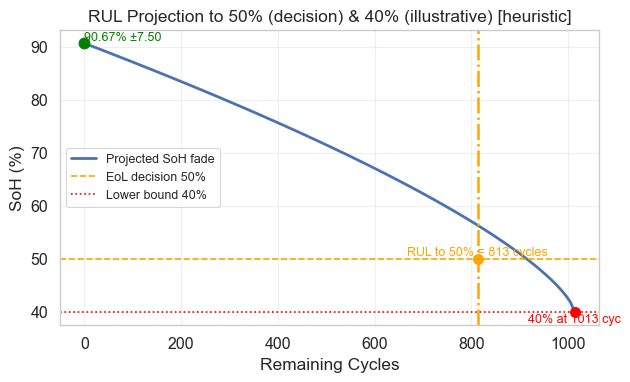

In [42]:
# ===== Updated EIS SoC / SoH / RUL (to 50% decision, plot to 40%) Debug Inference =====
from __future__ import annotations
import os, re, io, math, json, tempfile, warnings, traceback
from pathlib import Path
from typing import Dict, Tuple, Optional
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import interp1d

# ---------------- CONFIG ----------------
MODEL_BUNDLE_PATH        = Path("models_eis_phase1/eis_soc_soh_models.joblib")
EOL_DECISION_THRESHOLD   = 50.0   # End-of-life (RUL target) SoH (%)
CURVE_MIN_THRESHOLD      = 40.0   # Lower bound for plotting curve
CYCLES_PER_PERCENT_FADE  = 20.0   # Heuristic: cycles per 1% SoH drop (adjust!)
FADE_EXPONENT            = 0.7    # Concavity of fade projection (0<k<1 concave)
RUL_MODEL_KEY            = "rul_model"

FREQ_COL_CANDIDATES = ["frequency","freq","f","frequency(hz)","hz","Frequency(Hz)"]
RE_COL_CANDIDATES   = ["zreal","re(z)","re","real","z_re","z_real","zre","re (ohm)","re(z) (ohm)","Re","Re(Z)"]
IM_COL_CANDIDATES   = ["-zimag","zimag","im(z)","im","imag","imaginary","z_im","zimg","z_imag","Im","Im(Z)"]

FREQ_RANGE_PATTERN = re.compile(r"Freq-([0-9]*\.?[0-9]+)-([0-9]*\.?[0-9]+)Hz", re.IGNORECASE)
EIS_META_PATTERN   = re.compile(
    r"Cell(?P<CellID>\d+)_(?P<SOH>80|85|90|95|100)SOH_(?P<Temp>\d+)degC_(?P<SOC>\d+)SOC_(?P<RealSOH>\d+)"
)

# ---------------- LOAD MODEL -------------
if not MODEL_BUNDLE_PATH.exists():
    raise FileNotFoundError(f"Model bundle not found: {MODEL_BUNDLE_PATH}")
bundle          = joblib.load(MODEL_BUNDLE_PATH)
scaler          = bundle["scaler"]
soc_model       = bundle["soc_model"]
soh_model       = bundle["soh_model"]
freq_grid       = bundle["freq_grid"]
feature_version = bundle.get("feature_version")
rul_model       = bundle.get(RUL_MODEL_KEY)
expected_feature_dim = getattr(scaler, "n_features_in_", None)

print("Loaded model bundle with feature_version =", feature_version)

# ---------------- METADATA ---------------
def parse_metadata(stem: str) -> Dict:
    m = EIS_META_PATTERN.search(stem)
    if not m:
        return {}
    d = m.groupdict()
    return {
        "CellID": f"Cell{d['CellID']}",
        "SOH_stage": int(d["SOH"]),
        "Temp": int(d["Temp"]),
        "SOC_label": int(d["SOC"]),
        "RealSOH_file": int(d["RealSOH"]) / 100.0
    }

def parse_freq_range_from_name(name: str):
    m = FREQ_RANGE_PATTERN.search(name)
    if not m: return None, None
    hi, lo = float(m.group(1)), float(m.group(2))
    return (hi, lo) if hi >= lo else (lo, hi)

# ---------------- LOW LEVEL LOAD ----------
def _find_matrix_in_mat(mat_dict: dict):
    for v in mat_dict.values():
        if isinstance(v, np.ndarray) and v.ndim == 2 and v.shape[1] >= 3 and v.shape[0] >= 10:
            return v
    return None

def _interp_channel(freq_raw, y_raw, freq_target):
    if freq_raw[0] < freq_raw[-1]:
        freq_raw = freq_raw[::-1]; y_raw = y_raw[::-1]
    uniq, idx = np.unique(freq_raw, return_index=True)
    if len(uniq) != len(freq_raw):
        order = np.argsort(idx)
        freq_raw = uniq[order]; y_raw = y_raw[idx][order]
    f = interp1d(freq_raw, y_raw, kind="linear", bounds_error=False,
                 fill_value=(y_raw[0], y_raw[-1]))
    return f(freq_target)

def _select_column(df: pd.DataFrame, cands):
    low = {c.lower(): c for c in df.columns}
    for c in cands:
        if c.lower() in low: return low[c.lower()]
    for c in cands:
        for col in df.columns:
            if c.lower() in col.lower(): return col
    return None

# ----------- FILE LOADERS -----------------
def load_eis_from_mat(path: Path):
    mat = loadmat(path)
    arr = _find_matrix_in_mat(mat)
    if arr is None: raise ValueError("No valid EIS matrix in .mat file.")
    return arr[:,0].astype(float), arr[:,1].astype(float), arr[:,2].astype(float)

def load_eis_from_standard_table(path: Path):
    df = pd.read_csv(path) if path.suffix.lower()==".csv" else pd.read_excel(path)
    if df.empty: raise ValueError("Empty table.")
    f_col=_select_column(df,FREQ_COL_CANDIDATES); re_col=_select_column(df,RE_COL_CANDIDATES); im_col=_select_column(df,IM_COL_CANDIDATES)
    miss=[lbl for lbl,c in [("frequency",f_col),("real",re_col),("imag",im_col)] if c is None]
    if miss: raise ValueError(f"Missing columns {miss}; present={list(df.columns)}")
    f = pd.to_numeric(df[f_col],errors="coerce").dropna().to_numpy(float)
    r = pd.to_numeric(df[re_col],errors="coerce").dropna().to_numpy(float)
    im= pd.to_numeric(df[im_col],errors="coerce").dropna().to_numpy(float)
    n=min(len(f),len(r),len(im))
    return f[:n], r[:n], im[:n]

def load_eis_from_excel_generic(path: Path):
    raw = pd.read_excel(path, header=None)
    header_row=None
    for r in range(min(8,len(raw))):
        if "zreal" in " ".join(str(x) for x in raw.iloc[r].values).lower():
            header_row=r; break
    if header_row is not None:
        headers=raw.iloc[header_row].astype(str).tolist()
        data=raw.iloc[header_row+1:].reset_index(drop=True)
        data.columns=headers
    else:
        data=raw.copy(); data.columns=[f"col{i}" for i in range(data.shape[1])]
    real_col=imag_col=None
    for c in data.columns:
        cl=c.lower()
        if real_col is None and ("zreal" in cl or ("real" in cl and "img" not in cl)):
            real_col=c
        if imag_col is None and ("zimag" in cl or "-zimag" in cl or "imag" in cl):
            imag_col=c
    if real_col is None or imag_col is None:
        raise ValueError(f"Could not detect Zreal / Zimag columns: {list(data.columns)}")
    re_vals = pd.to_numeric(data[real_col], errors="coerce").dropna().to_numpy(float)
    im_vals = pd.to_numeric(data[imag_col], errors="coerce").dropna().to_numpy(float)
    n = min(len(re_vals), len(im_vals))
    re_vals, im_vals = re_vals[:n], im_vals[:n]
    if "-zimag" in imag_col.lower():  # restore conventional negative imag
        im_vals = -im_vals
    hi, lo = parse_freq_range_from_name(path.name)
    if hi is None:
        hi, lo = 5000.0, 0.01
    freq = np.geomspace(hi, lo, n)
    return freq, re_vals, im_vals

def load_eis_any(path: Path):
    suf = path.suffix.lower()
    if suf==".mat": return load_eis_from_mat(path)
    if suf==".csv": return load_eis_from_standard_table(path)
    if suf in [".xls",".xlsx"]:
        try: return load_eis_from_excel_generic(path)
        except Exception: return load_eis_from_standard_table(path)
    raise ValueError(f"Unsupported extension {suf}")

# ------------- FEATURES -------------------
def compute_F_features(freq, re_i, im_i):
    neg_im = -im_i
    idx_peak = int(np.argmax(neg_im))
    F1 = re_i[0]; F2 = re_i[idx_peak]; F3 = re_i[-1]
    sc = np.where(np.sign(im_i[:-1]) != np.sign(im_i[1:]))[0]
    if len(sc):
        k=sc[0]; y0,y1=im_i[k],im_i[k+1]; w=-y0/(y1-y0+1e-12)
        F4 = re_i[k] + w*(re_i[k+1]-re_i[k])
    else:
        F4 = math.nan
    F5 = (re_i[idx_peak]-F1) if idx_peak>0 else math.nan
    F6 = float(np.min(im_i))
    idx_mid = int(np.argmin(np.abs(freq - 10.0)))
    F7 = re_i[idx_mid]
    return [F1,F2,F3,F4,F5,F6,F7]

def build_feature_vector(re_i, im_i, temp, freq):
    z_mag = np.sqrt(re_i**2 + im_i**2)
    basics = [re_i[0], re_i[-1], re_i[-1]-re_i[0],
              float(z_mag.max()), float(z_mag.mean()), float(z_mag.std())]
    F_feats = compute_F_features(freq, re_i, im_i)
    vec = np.concatenate([re_i, im_i, basics, F_feats, [temp]])
    if not np.isfinite(vec).all():
        vec = np.nan_to_num(vec, nan=0.0, posinf=0.0, neginf=0.0)
    return vec

def featurize(path: Path, debug=True):
    f_raw, re_raw, im_raw = load_eis_any(path)
    if debug: print(f"[load] points={len(f_raw)}")
    re_i = _interp_channel(f_raw, re_raw, freq_grid)
    im_i = _interp_channel(f_raw, im_raw, freq_grid)
    if debug: print("[interp] shapes:", re_i.shape, im_i.shape)
    meta = parse_metadata(path.stem)
    temp = meta.get("Temp", -1)
    vec = build_feature_vector(re_i, im_i, temp, freq_grid)
    if debug: print(f"[features] len={len(vec)} expected={expected_feature_dim}")
    return vec, meta

# ------------- RUL (new logic) ------------
def heuristic_rul_to_threshold(current_soh: float, target_soh: float) -> float:
    """Linear fade assumption: cycles per % drop constant."""
    if current_soh <= target_soh:
        return 0.0
    delta = current_soh - target_soh
    return delta * CYCLES_PER_PERCENT_FADE  # cycles

def predict_rul(X_scaled, soh_mean):
    """If a trained RUL model exists (to 50%), use it; else heuristic."""
    if rul_model is not None:
        try:
            val = float(rul_model.predict(X_scaled)[0])
            return max(val, 0.0), "model"
        except Exception as e:
            warnings.warn(f"RUL model failed ({e}); using heuristic.")
    return heuristic_rul_to_threshold(soh_mean, EOL_DECISION_THRESHOLD), "heuristic"

def project_curve(current_soh: float, cycles_to_50: float, cycles_to_40: float, n=120):
    """
    Build a curve from 0 → cycles_to_40 ending at 40%.
    Use exponent fade anchored at decision (50%) along the trajectory.
    """
    total = max(cycles_to_40, 1e-6)
    c = np.linspace(0, total, n)
    # we shape relative to 40%; param so that at c = cycles_to_50 we hit ≈ 50%
    # Invert relation: SoH(c) = S_min + (S0 - S_min)*(1 - (c/total))^k
    S_min = CURVE_MIN_THRESHOLD
    S0 = current_soh
    k = FADE_EXPONENT
    soh_c = S_min + (S0 - S_min) * (1 - (c/total))**k
    return c, soh_c

def plot_projection(current_soh, soh_std, cycles_to_50, method):
    cycles_to_40 = heuristic_rul_to_threshold(current_soh, CURVE_MIN_THRESHOLD)
    c, soh_c = project_curve(current_soh, cycles_to_50, cycles_to_40)

    fig, ax = plt.subplots(figsize=(6.5,4))
    ax.plot(c, soh_c, label="Projected SoH fade", lw=2)
    ax.axhline(EOL_DECISION_THRESHOLD, color="orange", ls="--", label=f"EoL decision {EOL_DECISION_THRESHOLD:.0f}%")
    ax.axhline(CURVE_MIN_THRESHOLD, color="red", ls=":", label=f"Lower bound {CURVE_MIN_THRESHOLD:.0f}%")
    # Marker current
    ax.scatter([0],[current_soh], color="green", s=60, zorder=5)
    ax.text(0, current_soh+0.6, f"{current_soh:.2f}% ±{soh_std:.2f}", color="green", fontsize=9)
    # Marker at decision threshold
    ax.axvline(cycles_to_50, color="orange", ls="-.", lw=1.8)
    ax.scatter([cycles_to_50],[EOL_DECISION_THRESHOLD], color="orange", s=50, zorder=6)
    ax.text(cycles_to_50, EOL_DECISION_THRESHOLD+0.6,
            f"RUL to 50% = {cycles_to_50:.0f} cycles", color="orange", ha="center", fontsize=9)
    # End marker at 40%
    ax.scatter([c[-1]],[CURVE_MIN_THRESHOLD], color="red", s=50, zorder=6)
    ax.text(c[-1], CURVE_MIN_THRESHOLD-2,
            f"{CURVE_MIN_THRESHOLD:.0f}% at {c[-1]:.0f} cyc", color="red", ha="center", fontsize=9)
    ax.set_xlabel("Remaining Cycles")
    ax.set_ylabel("SoH (%)")
    ax.set_title(f"RUL Projection to 50% (decision) & 40% (illustrative) [{method}]")
    ax.grid(alpha=0.3)
    ax.legend(fontsize=9)
    fig.tight_layout()
    return fig, cycles_to_40

# ------------- PREDICT --------------------
def predict_file(path: str | Path, debug=True, plot=True):
    path = Path(path)
    if debug: print(f"\n=== Predict: {path} ===")
    feat_vec, meta = featurize(path, debug=debug)
    if expected_feature_dim and feat_vec.shape[0] != expected_feature_dim:
        if feat_vec.shape[0] > expected_feature_dim:
            feat_vec = feat_vec[:expected_feature_dim]
        else:
            feat_vec = np.pad(feat_vec,(0,expected_feature_dim-feat_vec.shape[0]),constant_values=0.0)
        if debug: print("[adjust] feature length aligned to expected.")
    X_scaled = scaler.transform(feat_vec.reshape(1,-1))
    # SoC
    soc_probs = soc_model.predict_proba(X_scaled)[0]
    soc_classes = soc_model.classes_
    soc_pred = int(soc_classes[np.argmax(soc_probs)])
    # SoH
    soh_mean_arr, soh_std_arr = soh_model.predict(X_scaled, return_std=True)
    soh_mean = float(soh_mean_arr[0]); soh_std=float(soh_std_arr[0])
    # RUL (to 50%)
    cycles_to_50, method = predict_rul(X_scaled, soh_mean)
    cycles_to_40 = heuristic_rul_to_threshold(soh_mean, CURVE_MIN_THRESHOLD)
    fig = None
    if plot:
        fig, _ = plot_projection(soh_mean, soh_std, cycles_to_50, method)

    result = {
        "file": path.name,
        "parsed_metadata": meta,
        "predicted_SoC": soc_pred,
        "SoC_probabilities": {int(c): float(p) for c,p in zip(soc_classes, soc_probs)},
        "predicted_SoH_percent": soh_mean,
        "SoH_std_estimate": soh_std,
        "cycles_to_50pct_EoL": cycles_to_50,
        "cycles_to_40pct_lower_bound": cycles_to_40,
        "decision_threshold_percent": EOL_DECISION_THRESHOLD,
        "lower_bound_percent": CURVE_MIN_THRESHOLD,
        "cycles_per_percent_fade_used": CYCLES_PER_PERCENT_FADE,
        "RUL_method": method,
        "feature_version": feature_version
    }
    if debug:
        print(json.dumps(result, indent=2))
    return result, fig

# ------------- QUICK TEST -----------------
TEST_FILE = "Mazda-Battery-Cell2.xlsx"  # replace with your test file path
if Path(TEST_FILE).exists():
    res, fig = predict_file(TEST_FILE, debug=True, plot=True)
    display(fig)
else:
    print("Test file not found; upload & rerun.")
